# Proyecto de series de tiempo univariadas (Red Neuronal Recurrente)
El siguiente Script abarca la modelación del PIB en Colombia; desde enero de 2005 hasta diciembre de 2023; utilizando redes neuronales recurrentes
## Integrantes: Anderson Guarín, Ander Cristancho, Juan Duitama

## Librerías utilizadas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
from datetime import timedelta

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV

import tensorflow.keras as keras

## Importación datos

In [2]:
import os
#Directorio Anderson
os.chdir(r"C:\Users\ander\OneDrive - Universidad Nacional de Colombia\Documentos\(2024-01) Octavo Semestre\Series de Tiempo Univariadas\Proyecto")
#Directorio Duitama
#os.chdir("D:\Estadística\Semestres\Semestre 9\Series de Tiempo Univariadas\Datos")
#Directorio Ander
#os.chdir(r"C:\Users\EQUIPO\OneDrive\Documentos\Documentos Ander\UNAL\Series de tiempo\Mis series y descriptiva")
os.getcwd()

'C:\\Users\\ander\\OneDrive - Universidad Nacional de Colombia\\Documentos\\(2024-01) Octavo Semestre\\Series de Tiempo Univariadas\\Proyecto'

In [3]:
DatosPIB = pd.read_excel("PIB.xlsx",skiprows=16,nrows=77)
DatosPIB = DatosPIB.iloc[:,[0,44]]
print(DatosPIB.dtypes)
# Cambiar los nombres de las columnas
col_names = ['Anio-Trimestre','PIB']
DatosPIB.columns = col_names
# Uso de nuevo df
DatosPIB['Anio-Trimestre'] = DatosPIB['Anio-Trimestre'].astype(str)
DatosPIB['Anio-Trimestre']=DatosPIB['Anio-Trimestre'].str[:4] + '-' + DatosPIB['Anio-Trimestre'].str[4:]
# Mapeo de trimestres a meses
trimestre_a_mes = {
    '01': '01',
    '02': '04',
    '03': '07',
    '04': '10'
}
# Crear una columna de fechas basada en el mapeo
DatosPIB['Anio-Trimestre'] = DatosPIB['Anio-Trimestre'].str[:4] + '-' + DatosPIB['Anio-Trimestre'].str[5:].map(trimestre_a_mes)
DatosPIB

Año(aaaa)Trimestre(tt)      int64
Valor.14                  float64
dtype: object


Anio-Trimestre            PIB
0         2005-01  126125.790850
1         2005-04  128871.539452
2         2005-07  128599.726108
3         2005-10  131255.943474
4         2006-01  134234.013588
..            ...            ...
71        2022-10  243369.962678
72        2023-01  246785.261057
73        2023-04  243240.731918
74        2023-07  244066.682319
75        2023-10  244157.551456

[76 rows x 2 columns]

In [7]:
#Primera observación de los datos
DatosPIB['Anio-Trimestre']=pd.to_datetime(DatosPIB['Anio-Trimestre']) #Convirtiendo la columna año y trimestre a formato fecha. 
DatosPIB=DatosPIB.set_index('Anio-Trimestre')
DatosPIB

PIB
Anio-Trimestre               
2005-01-01      126125.790850
2005-04-01      128871.539452
2005-07-01      128599.726108
2005-10-01      131255.943474
2006-01-01      134234.013588
...                       ...
2022-10-01      243369.962678
2023-01-01      246785.261057
2023-04-01      243240.731918
2023-07-01      244066.682319
2023-10-01      244157.551456

[76 rows x 1 columns]

El análisis descriptivo fue realizado en scripts previos, de los cuales se seleccionaron los retardos 2,3,4 como features.

## Organización de los datos
Utilizaremos el 80% de los datos como entrenamiento y el 20% restante como prueba.

In [8]:
split = int(len(DatosPIB) * 0.8)
DataTrain = DatosPIB.iloc[:split]
DataTest = DatosPIB.iloc[split:]

n_steps = 4 #Utilizaremos los 4 retardos
n_steps_ahead = 1 #Predicción a un paso

Estandarización

In [9]:
mu = float(DataTrain.mean())
sigma = float(DataTrain.std())

stdize_input = lambda x: (x - mu) / sigma

DataTrain = DataTrain.apply(stdize_input)
DataTest = DataTest.apply(stdize_input)

Creando los tensores con los retardos

In [10]:
def get_lagged_features(df, n_steps, n_steps_ahead):
    """
    df: pandas DataFrame of time series to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    lag_array = np.dstack([i[n_steps+n_steps_ahead-1:] for i in lag_list])
    # We swap the last two dimensions so each slice along the first dimension
    # is the same shape as the corresponding segment of the input time series 
    lag_array = np.swapaxes(lag_array, 1, -1)
    return lag_array

Entrenamiento

In [11]:
x_train = get_lagged_features(DataTrain, n_steps, n_steps_ahead)
y_train =  DataTrain.values[n_steps + n_steps_ahead - 1:]
y_train_timestamps = DataTrain.index[n_steps + n_steps_ahead - 1:]

Prueba

In [12]:
x_test = get_lagged_features(DataTest, n_steps, n_steps_ahead)
y_test =  DataTest.values[n_steps + n_steps_ahead - 1:]
y_test_timestamps = DataTest.index[n_steps + n_steps_ahead - 1:]

In [13]:
print([tensor.shape for tensor in (x_train, y_train, x_test, y_test)])

[(56, 4, 1), (56, 1), (12, 4, 1), (12, 1)]


## Creación de las redes neuronales
Tres redes neuronales recurrentes serán implementadas, una simple, una GRU (Gated Recurrent Unit) y una LSTM (Long Short-Term Memory).

In [14]:
def SimpleRNN_(n_units, l1_reg, seed=1729):
  #def SimpleRNN_(n_units = 10, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.L1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True, stateful=False))  
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.L1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

def GRU_(n_units, l1_reg, seed=1729):
  #def GRU_(n_units = 10, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.L1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True))  
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.L1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

def LSTM_(n_units, l1_reg, seed=1729):
  #def LSTM_(n_units = 10,  seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.L1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True)) 
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.L1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

Definimos las épocas y mantenemos un batch de 1

In [15]:
max_epochs = 100 #Definimos 100 épocas
batch_size = 1# Mantenemos el tamaño del batch

In [16]:
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10, min_delta=1e-7, restore_best_weights=True)
params = {
    'rnn': {
        'model': None, 'function': SimpleRNN_, 'l1_reg': 0.0, 'H': 20, 
        'color': 'blue', 'label':'RNN'}, 
    'gru': {
        'model': None, 'function':GRU_,'l1_reg': 0.0, 'H': 10, 
        'color': 'orange', 'label': 'GRU'},
    'lstm': {
        'model': None, 'function': LSTM_,'l1_reg': 0.0, 'H': 10, 
        'color':'red', 'label': 'LSTM'}
}

In [17]:
do_training = True

## Validación Cruzada

In [18]:
from scikeras.wrappers import KerasRegressor

In [19]:
cross_val = True # WARNING: Changing this to True will take many hours to run

if do_training and cross_val:
    n_units = [5, 10, 20]
    l1_reg = [0, 0.001, 0.01, 0.1]
    
    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search
    param_grid = {'n_units': n_units, 'l1_reg': l1_reg}
    
    # In the kth split, TimeSeriesSplit returns first k folds 
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits = 5)
    
    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params.keys():
        print('Performing cross-validation. Model:', key)
        model = KerasRegressor(model=params[key]['function'], epochs=max_epochs, 
                               batch_size=batch_size, verbose=2, l1_reg=0, n_units=10)
        #from scikeras.wrappers import KerasClassifier, KerasRegressor
        grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                            cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train, y_train, callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))
            
        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']

Performing cross-validation. Model: rnn
Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
[CV] END ................................l1_reg=0, n_units=5; total time=   1.5s


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
[CV] END ................................l1_reg=0, n_units=5; total time=   0.4s


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
[CV] END ................................l1_reg=0, n_units=5; total time=   0.4s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ................................l1_reg=0, n_units=5; total time=   0.1s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ................................l1_reg=0, n_units=5; total time=   0.1s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=10; total time=   0.2s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=10; total time=   0.1s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=10; total time=   0.2s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=10; total time=   0.1s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=10; total time=   0.1s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=20; total time=   0.2s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=20; total time=   0.2s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=20; total time=   0.2s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=20; total time=   0.1s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=20; total time=   0.2s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 3s - 260ms/step - loss: 0.0604
Epoch 2/100
11/11 - 0s - 5ms/step - loss: 0.0562
Epoch 3/100
11/11 - 0s - 5ms/step - loss: 0.0542
Epoch 4/100
11/11 - 0s - 4ms/step - loss: 0.0664
Epoch 5/100
11/11 - 0s - 4ms/step - loss: 0.0760
Epoch 6/100
11/11 - 0s - 4ms/step - loss: 0.0848
Epoch 7/100
11/11 - 0s - 5ms/step - loss: 0.0876
Epoch 8/100
11/11 - 0s - 4ms/step - loss: 0.0888
Epoch 9/100
11/11 - 0s - 5ms/step - loss: 0.0832
Epoch 10/100
11/11 - 0s - 4ms/step - loss: 0.1981
Epoch 11/100
11/11 - 0s - 5ms/step - loss: 0.1847
Epoch 12/100
11/11 - 0s - 5ms/step - loss: 0.1707
Epoch 13/100
11/11 - 0s - 6ms/step - loss: 0.1645
Epoch 14/100
11/11 - 0s - 7ms/step - loss: 0.1573
Epoch 15/100
11/11 - 0s - 7ms/step - loss: 0.1548
Epoch 16/100
11/11 - 0s - 6ms/step - loss: 0.2418
Epoch 17/100
11/11 - 0s - 6ms/step - loss: 0.9911
Epoch 18/100
11/11 - 0s - 6ms/step - loss: 1.0457
Epoch 19/100
11/11 - 0s - 6ms/step - loss: 1.0249
Epoch 20/100
11/11 - 0s - 5ms/step - loss: 0.9768
Epoch 21/100
11/11 

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
20/20 - 2s - 87ms/step - loss: 0.2195
Epoch 2/100
20/20 - 0s - 5ms/step - loss: 0.2072
Epoch 3/100
20/20 - 0s - 5ms/step - loss: 0.5042
Epoch 4/100
20/20 - 0s - 5ms/step - loss: 0.6179
Epoch 5/100
20/20 - 0s - 5ms/step - loss: 1.0091
Epoch 6/100
20/20 - 0s - 6ms/step - loss: 0.9845
Epoch 7/100
20/20 - 0s - 5ms/step - loss: 1.1164
Epoch 8/100
20/20 - 0s - 5ms/step - loss: 1.0675
Epoch 9/100
20/20 - 0s - 5ms/step - loss: 0.5171
Epoch 10/100
20/20 - 0s - 4ms/step - loss: 0.5781
Epoch 11/100
20/20 - 0s - 4ms/step - loss: 0.3332
Epoch 12/100
20/20 - 0s - 4ms/step - loss: 0.3910
Epoch 13/100
20/20 - 0s - 4ms/step - loss: 0.6368
Epoch 14/100
20/20 - 0s - 4ms/step - loss: 0.9610
Epoch 15/100
20/20 - 0s - 4ms/step - loss: 1.0860
Epoch 16/100
20/20 - 0s - 4ms/step - loss: 1.4655
Epoch 17/100
20/20 - 0s - 4ms/step - loss: 1.5673
Epoch 18/100
20/20 - 0s - 4ms/step - loss: 0.8535
Epoch 19/100
20/20 - 0s - 4ms/step - loss: 0.8363
Epoch 20/100
20/20 - 0s - 4ms/step - loss: 0.7397
Epoch 21

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 2s - 56ms/step - loss: 2.0372
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 2.2004
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 2.2171
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 3.1291
Epoch 5/100
29/29 - 0s - 3ms/step - loss: 3.8056
Epoch 6/100
29/29 - 0s - 3ms/step - loss: 3.5025
Epoch 7/100
29/29 - 0s - 3ms/step - loss: 3.1548
Epoch 8/100
29/29 - 0s - 3ms/step - loss: 2.6736
Epoch 9/100
29/29 - 0s - 3ms/step - loss: 2.4411
Epoch 10/100
29/29 - 0s - 3ms/step - loss: 2.3938
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 2.2904
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 1.7417
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 1.4722
Epoch 14/100
29/29 - 0s - 3ms/step - loss: 1.5500
Epoch 15/100
29/29 - 0s - 5ms/step - loss: 1.4138
Epoch 16/100
29/29 - 0s - 7ms/step - loss: 1.4236
Epoch 17/100
29/29 - 0s - 4ms/step - loss: 1.2460
Epoch 18/100
29/29 - 0s - 4ms/step - loss: 0.9214
Epoch 19/100
29/29 - 0s - 7ms/step - loss: 0.6743
Epoch 20/100
29/29 - 0s - 7ms/step - loss: 0.5142
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 2s - 47ms/step - loss: 5.6627
Epoch 2/100
38/38 - 0s - 8ms/step - loss: 5.0718
Epoch 3/100
38/38 - 0s - 7ms/step - loss: 4.6046
Epoch 4/100
38/38 - 0s - 7ms/step - loss: 4.1593
Epoch 5/100
38/38 - 0s - 6ms/step - loss: 3.6764
Epoch 6/100
38/38 - 0s - 7ms/step - loss: 3.2529
Epoch 7/100
38/38 - 0s - 6ms/step - loss: 2.8686
Epoch 8/100
38/38 - 0s - 5ms/step - loss: 2.5845
Epoch 9/100
38/38 - 0s - 5ms/step - loss: 2.2834
Epoch 10/100
38/38 - 0s - 7ms/step - loss: 1.9410
Epoch 11/100
38/38 - 0s - 7ms/step - loss: 1.6846
Epoch 12/100
38/38 - 0s - 6ms/step - loss: 1.4320
Epoch 13/100
38/38 - 0s - 6ms/step - loss: 1.2615
Epoch 14/100
38/38 - 0s - 5ms/step - loss: 1.1057
Epoch 15/100
38/38 - 0s - 5ms/step - loss: 0.9935
Epoch 16/100
38/38 - 0s - 4ms/step - loss: 0.8968
Epoch 17/100
38/38 - 0s - 5ms/step - loss: 0.8225
Epoch 18/100
38/38 - 0s - 9ms/step - loss: 0.7625
Epoch 19/100
38/38 - 0s - 6ms/step - loss: 0.7188
Epoch 20/100
38/38 - 0s - 7ms/step - loss: 0.6772
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 2s - 32ms/step - loss: 4.2437
Epoch 2/100
47/47 - 0s - 3ms/step - loss: 4.7995
Epoch 3/100
47/47 - 0s - 2ms/step - loss: 3.2103
Epoch 4/100
47/47 - 0s - 2ms/step - loss: 2.2769
Epoch 5/100
47/47 - 0s - 2ms/step - loss: 1.1187
Epoch 6/100
47/47 - 0s - 2ms/step - loss: 0.5724
Epoch 7/100
47/47 - 0s - 2ms/step - loss: 0.4389
Epoch 8/100
47/47 - 0s - 2ms/step - loss: 0.4700
Epoch 9/100
47/47 - 0s - 2ms/step - loss: 0.6278
Epoch 10/100
47/47 - 0s - 2ms/step - loss: 0.4941
Epoch 11/100
47/47 - 0s - 2ms/step - loss: 0.4147
Epoch 12/100
47/47 - 0s - 2ms/step - loss: 0.2501
Epoch 13/100
47/47 - 0s - 2ms/step - loss: 0.3228
Epoch 14/100
47/47 - 0s - 2ms/step - loss: 0.4930
Epoch 15/100
47/47 - 0s - 3ms/step - loss: 0.5437
Epoch 16/100
47/47 - 0s - 2ms/step - loss: 0.5705
Epoch 17/100
47/47 - 0s - 2ms/step - loss: 0.5271
Epoch 18/100
47/47 - 0s - 2ms/step - loss: 0.4270
Epoch 19/100
47/47 - 0s - 2ms/step - loss: 0.5347
Epoch 20/100
47/47 - 0s - 2ms/step - loss: 0.6758
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 3s - 298ms/step - loss: 0.1344
Epoch 2/100
11/11 - 0s - 5ms/step - loss: 0.0455
Epoch 3/100
11/11 - 0s - 5ms/step - loss: 0.1446
Epoch 4/100
11/11 - 0s - 5ms/step - loss: 1.1773
Epoch 5/100
11/11 - 0s - 5ms/step - loss: 2.0987
Epoch 6/100
11/11 - 0s - 5ms/step - loss: 1.8819
Epoch 7/100
11/11 - 0s - 5ms/step - loss: 3.1957
Epoch 8/100
11/11 - 0s - 5ms/step - loss: 2.5324
Epoch 9/100
11/11 - 0s - 5ms/step - loss: 2.6649
Epoch 10/100
11/11 - 0s - 5ms/step - loss: 3.0629
Epoch 11/100
11/11 - 0s - 5ms/step - loss: 2.9316
Epoch 12/100
11/11 - 0s - 5ms/step - loss: 2.3772
Epoch 13/100
11/11 - 0s - 5ms/step - loss: 1.9412
Epoch 14/100
11/11 - 0s - 5ms/step - loss: 1.7807
Epoch 15/100
11/11 - 0s - 5ms/step - loss: 1.4767
Epoch 16/100
11/11 - 0s - 5ms/step - loss: 0.9691
Epoch 17/100
11/11 - 0s - 5ms/step - loss: 0.8351
Epoch 18/100
11/11 - 0s - 5ms/step - loss: 0.7908
Epoch 19/100
11/11 - 0s - 5ms/step - loss: 1.0730
Epoch 20/100
11/11 - 0s - 6ms/step - loss: 0.9947
Epoch 21/100
11/11 

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 54ms/step - loss: 3.4287
Epoch 2/100
20/20 - 0s - 3ms/step - loss: 2.0601
Epoch 3/100
20/20 - 0s - 3ms/step - loss: 0.9349
Epoch 4/100
20/20 - 0s - 3ms/step - loss: 0.7000
Epoch 5/100
20/20 - 0s - 3ms/step - loss: 0.7051
Epoch 6/100
20/20 - 0s - 4ms/step - loss: 1.4825
Epoch 7/100
20/20 - 0s - 4ms/step - loss: 0.5628
Epoch 8/100
20/20 - 0s - 3ms/step - loss: 0.8207
Epoch 9/100
20/20 - 0s - 4ms/step - loss: 0.5964
Epoch 10/100
20/20 - 0s - 3ms/step - loss: 0.9101
Epoch 11/100
20/20 - 0s - 3ms/step - loss: 1.1369
Epoch 12/100
20/20 - 0s - 4ms/step - loss: 1.0086
Epoch 13/100
20/20 - 0s - 4ms/step - loss: 0.8882
Epoch 14/100
20/20 - 0s - 4ms/step - loss: 0.8384
Epoch 15/100
20/20 - 0s - 3ms/step - loss: 0.8307
Epoch 16/100
20/20 - 0s - 4ms/step - loss: 0.6664
Epoch 17/100
20/20 - 0s - 3ms/step - loss: 0.8200
Epoch 18/100
20/20 - 0s - 3ms/step - loss: 0.6867
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 1.0883
Epoch 20/100
20/20 - 0s - 3ms/step - loss: 1.0494
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 43ms/step - loss: 2.1130
Epoch 2/100
29/29 - 0s - 3ms/step - loss: 2.0306
Epoch 3/100
29/29 - 0s - 3ms/step - loss: 1.7508
Epoch 4/100
29/29 - 0s - 3ms/step - loss: 1.4995
Epoch 5/100
29/29 - 0s - 3ms/step - loss: 1.6585
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 1.7624
Epoch 7/100
29/29 - 0s - 3ms/step - loss: 1.3590
Epoch 8/100
29/29 - 0s - 3ms/step - loss: 1.3354
Epoch 9/100
29/29 - 0s - 3ms/step - loss: 1.5539
Epoch 10/100
29/29 - 0s - 3ms/step - loss: 1.3909
Epoch 11/100
29/29 - 0s - 5ms/step - loss: 1.1727
Epoch 12/100
29/29 - 0s - 5ms/step - loss: 1.1093
Epoch 13/100
29/29 - 0s - 5ms/step - loss: 0.9513
Epoch 14/100
29/29 - 0s - 5ms/step - loss: 0.9582
Epoch 15/100
29/29 - 0s - 5ms/step - loss: 0.8222
Epoch 16/100
29/29 - 0s - 5ms/step - loss: 0.8152
Epoch 17/100
29/29 - 0s - 5ms/step - loss: 0.7202
Epoch 18/100
29/29 - 0s - 5ms/step - loss: 0.7161
Epoch 19/100
29/29 - 0s - 5ms/step - loss: 0.6501
Epoch 20/100
29/29 - 0s - 5ms/step - loss: 0.3456
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 33ms/step - loss: 0.9403
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 0.7984
Epoch 3/100
38/38 - 0s - 2ms/step - loss: 0.5760
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 0.4335
Epoch 5/100
38/38 - 0s - 2ms/step - loss: 0.5832
Epoch 6/100
38/38 - 0s - 2ms/step - loss: 0.8391
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 0.4455
Epoch 8/100
38/38 - 0s - 2ms/step - loss: 0.3439
Epoch 9/100
38/38 - 0s - 2ms/step - loss: 0.3863
Epoch 10/100
38/38 - 0s - 2ms/step - loss: 0.3957
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 0.3991
Epoch 12/100
38/38 - 0s - 3ms/step - loss: 0.4511
Epoch 13/100
38/38 - 0s - 3ms/step - loss: 0.4552
Epoch 14/100
38/38 - 0s - 3ms/step - loss: 0.4753
Epoch 15/100
38/38 - 0s - 3ms/step - loss: 0.4703
Epoch 16/100
38/38 - 0s - 6ms/step - loss: 0.4693
Epoch 17/100
38/38 - 0s - 8ms/step - loss: 0.4685
Epoch 18/100
38/38 - 0s - 5ms/step - loss: 0.4720
Epoch 19/100
38/38 - 0s - 5ms/step - loss: 0.4712
Epoch 20/100
38/38 - 0s - 5ms/step - loss: 0.4737
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 2s - 35ms/step - loss: 8.1100
Epoch 2/100
47/47 - 0s - 2ms/step - loss: 6.0817
Epoch 3/100
47/47 - 0s - 2ms/step - loss: 4.5938
Epoch 4/100
47/47 - 0s - 2ms/step - loss: 3.0508
Epoch 5/100
47/47 - 0s - 3ms/step - loss: 2.6307
Epoch 6/100
47/47 - 0s - 3ms/step - loss: 2.3517
Epoch 7/100
47/47 - 0s - 3ms/step - loss: 2.0088
Epoch 8/100
47/47 - 0s - 3ms/step - loss: 1.7286
Epoch 9/100
47/47 - 0s - 2ms/step - loss: 1.3523
Epoch 10/100
47/47 - 0s - 3ms/step - loss: 1.0315
Epoch 11/100
47/47 - 0s - 3ms/step - loss: 0.8218
Epoch 12/100
47/47 - 0s - 2ms/step - loss: 0.6901
Epoch 13/100
47/47 - 0s - 3ms/step - loss: 0.6053
Epoch 14/100
47/47 - 0s - 3ms/step - loss: 0.5274
Epoch 15/100
47/47 - 0s - 3ms/step - loss: 0.6625
Epoch 16/100
47/47 - 0s - 3ms/step - loss: 0.6635
Epoch 17/100
47/47 - 0s - 3ms/step - loss: 0.6653
Epoch 18/100
47/47 - 0s - 3ms/step - loss: 0.6634
Epoch 19/100
47/47 - 0s - 3ms/step - loss: 0.6630
Epoch 20/100
47/47 - 0s - 3ms/step - loss: 0.6618
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 83ms/step - loss: 1.2935
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 1.1268
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 0.5117
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 0.3549
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 0.2643
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 0.0687
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.0878
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 0.8143
Epoch 9/100
11/11 - 0s - 4ms/step - loss: 1.1552
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.8041
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 1.8526
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 2.9287
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 2.3113
Epoch 14/100
11/11 - 0s - 4ms/step - loss: 1.7488
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 1.8509
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 1.1730
Epoch 17/100
11/11 - 0s - 12ms/step - loss: 0.5375
Epoch 18/100
11/11 - 0s - 4ms/step - loss: 0.7693
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 1.6445
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.9865
Epoch 21/100
11/11 

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 37ms/step - loss: 0.4749
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 0.5039
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 1.4508
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 1.0461
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 1.0771
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 0.6285
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 0.7605
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.7573
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.6717
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.3852
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.4553
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.4382
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.1850
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.1197
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.1846
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.4826
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.5091
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.4435
Epoch 19/100
20/20 - 0s - 3ms/step - loss: 0.4105
Epoch 20/100
20/20 - 0s - 3ms/step - loss: 0.3753
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 30ms/step - loss: 0.8926
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 1.2176
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 1.6898
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 3.0157
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 2.5737
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 2.2321
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 1.5483
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 0.9379
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 0.8982
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 0.9603
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 0.7233
Epoch 12/100
29/29 - 0s - 4ms/step - loss: 0.4376
Epoch 13/100
29/29 - 0s - 3ms/step - loss: 0.2261
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 0.1241
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 0.0932
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.0754
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.0636
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.0608
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.0577
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.0559
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 26ms/step - loss: 2.8261
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 2.5929
Epoch 3/100
38/38 - 0s - 2ms/step - loss: 1.8143
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 1.8922
Epoch 5/100
38/38 - 0s - 2ms/step - loss: 0.9705
Epoch 6/100
38/38 - 0s - 2ms/step - loss: 0.7333
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 0.5695
Epoch 8/100
38/38 - 0s - 2ms/step - loss: 0.9792
Epoch 9/100
38/38 - 0s - 2ms/step - loss: 0.7189
Epoch 10/100
38/38 - 0s - 2ms/step - loss: 0.8441
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 0.3783
Epoch 12/100
38/38 - 0s - 2ms/step - loss: 0.3664
Epoch 13/100
38/38 - 0s - 2ms/step - loss: 0.3544
Epoch 14/100
38/38 - 0s - 2ms/step - loss: 0.4807
Epoch 15/100
38/38 - 0s - 2ms/step - loss: 0.4677
Epoch 16/100
38/38 - 0s - 2ms/step - loss: 0.3372
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 0.3151
Epoch 18/100
38/38 - 0s - 2ms/step - loss: 0.3055
Epoch 19/100
38/38 - 0s - 2ms/step - loss: 0.3550
Epoch 20/100
38/38 - 0s - 2ms/step - loss: 0.2923
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 20ms/step - loss: 5.1948
Epoch 2/100
47/47 - 0s - 2ms/step - loss: 3.3219
Epoch 3/100
47/47 - 0s - 2ms/step - loss: 1.3003
Epoch 4/100
47/47 - 0s - 2ms/step - loss: 0.8485
Epoch 5/100
47/47 - 0s - 2ms/step - loss: 0.5792
Epoch 6/100
47/47 - 0s - 2ms/step - loss: 0.3685
Epoch 7/100
47/47 - 0s - 2ms/step - loss: 0.2790
Epoch 8/100
47/47 - 0s - 2ms/step - loss: 0.3906
Epoch 9/100
47/47 - 0s - 2ms/step - loss: 0.4625
Epoch 10/100
47/47 - 0s - 2ms/step - loss: 0.6063
Epoch 11/100
47/47 - 0s - 2ms/step - loss: 0.2738
Epoch 12/100
47/47 - 0s - 2ms/step - loss: 0.1869
Epoch 13/100
47/47 - 0s - 2ms/step - loss: 0.1508
Epoch 14/100
47/47 - 0s - 2ms/step - loss: 0.1395
Epoch 15/100
47/47 - 0s - 2ms/step - loss: 0.1205
Epoch 16/100
47/47 - 0s - 2ms/step - loss: 0.1152
Epoch 17/100
47/47 - 0s - 2ms/step - loss: 0.1039
Epoch 18/100
47/47 - 0s - 2ms/step - loss: 0.0870
Epoch 19/100
47/47 - 0s - 2ms/step - loss: 0.2228
Epoch 20/100
47/47 - 0s - 2ms/step - loss: 0.2130
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 111ms/step - loss: 1.1388
Epoch 2/100
11/11 - 0s - 12ms/step - loss: 1.0074
Epoch 3/100
11/11 - 0s - 4ms/step - loss: 0.8928
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 0.7856
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 0.6912
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 0.8983
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.8287
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 1.4623
Epoch 9/100
11/11 - 0s - 4ms/step - loss: 1.6791
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 1.8617
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 2.0345
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 2.7367
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 3.4472
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 3.3827
Epoch 15/100
11/11 - 0s - 4ms/step - loss: 2.9219
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 2.7674
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 2.6201
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 2.8317
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 2.4681
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 2.6394
Epoch 21/100
11/11

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 52ms/step - loss: 3.6836
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 3.2725
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 3.0135
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 2.8110
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 1.8916
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 1.6498
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 1.4273
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 1.0234
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.9319
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.8803
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.7454
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.7089
Epoch 13/100
20/20 - 0s - 3ms/step - loss: 0.6961
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.5415
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.5256
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.4566
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.4303
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.4463
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.4701
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.4272
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 25ms/step - loss: 4.3221
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 3.7462
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 3.4292
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 3.0792
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 2.6227
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 2.3478
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 2.2167
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 2.1357
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 2.1789
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 2.0057
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 1.9595
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 1.6945
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 1.4191
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 1.2080
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 1.0838
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.9796
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.8529
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.7354
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.6178
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.5351
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 24ms/step - loss: 3.4065
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 4.5755
Epoch 3/100
38/38 - 0s - 2ms/step - loss: 4.0252
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 3.5499
Epoch 5/100
38/38 - 0s - 2ms/step - loss: 3.3966
Epoch 6/100
38/38 - 0s - 2ms/step - loss: 3.1546
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 2.8264
Epoch 8/100
38/38 - 0s - 2ms/step - loss: 2.3688
Epoch 9/100
38/38 - 0s - 2ms/step - loss: 1.9868
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 1.8503
Epoch 11/100
38/38 - 0s - 1ms/step - loss: 1.7369
Epoch 12/100
38/38 - 0s - 5ms/step - loss: 1.6327
Epoch 13/100
38/38 - 0s - 2ms/step - loss: 1.5205
Epoch 14/100
38/38 - 0s - 2ms/step - loss: 1.4158
Epoch 15/100
38/38 - 0s - 2ms/step - loss: 1.3193
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 1.2278
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 1.1402
Epoch 18/100
38/38 - 0s - 2ms/step - loss: 1.0611
Epoch 19/100
38/38 - 0s - 2ms/step - loss: 0.9870
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 0.9159
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 18ms/step - loss: 5.4858
Epoch 2/100
47/47 - 0s - 2ms/step - loss: 4.8556
Epoch 3/100
47/47 - 0s - 2ms/step - loss: 3.9718
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 3.5392
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 3.4114
Epoch 6/100
47/47 - 0s - 2ms/step - loss: 3.3975
Epoch 7/100
47/47 - 0s - 2ms/step - loss: 2.8290
Epoch 8/100
47/47 - 0s - 2ms/step - loss: 2.3404
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 1.9025
Epoch 10/100
47/47 - 0s - 2ms/step - loss: 1.3973
Epoch 11/100
47/47 - 0s - 2ms/step - loss: 1.2160
Epoch 12/100
47/47 - 0s - 2ms/step - loss: 1.0682
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 0.9335
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 0.8149
Epoch 15/100
47/47 - 0s - 2ms/step - loss: 0.7725
Epoch 16/100
47/47 - 0s - 2ms/step - loss: 0.7413
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 0.7236
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 0.7057
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 0.6962
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 0.6901
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 83ms/step - loss: 0.4806
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 0.3586
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 0.2628
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 0.2041
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 0.1612
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 0.1397
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.1250
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 0.5511
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.3628
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.3447
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.6633
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 0.5754
Epoch 13/100
11/11 - 0s - 4ms/step - loss: 0.3279
Epoch 14/100
11/11 - 0s - 4ms/step - loss: 0.4660
Epoch 15/100
11/11 - 0s - 4ms/step - loss: 0.3415
Epoch 16/100
11/11 - 0s - 4ms/step - loss: 0.6252
Epoch 17/100
11/11 - 0s - 4ms/step - loss: 0.7641
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 0.3318
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 0.5887
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.8276
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 40ms/step - loss: 1.2326
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 0.5986
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 0.4125
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 0.4427
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 0.5280
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 0.5400
Epoch 7/100
20/20 - 0s - 3ms/step - loss: 0.2543
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.2398
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.3085
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.6880
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.9212
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.8086
Epoch 13/100
20/20 - 0s - 3ms/step - loss: 0.6797
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.5679
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.2586
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.1878
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.1576
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.1676
Epoch 19/100
20/20 - 0s - 3ms/step - loss: 0.0857
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.1148
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 28ms/step - loss: 1.6688
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 1.9347
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 1.9873
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 2.1959
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 1.9282
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 1.6574
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 1.3969
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 1.1815
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 0.7713
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 0.6029
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 0.5638
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 0.3185
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 0.1801
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 0.1496
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 0.1749
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.1708
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.1897
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.2317
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.2387
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.2233
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 24ms/step - loss: 2.3255
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 0.8418
Epoch 3/100
38/38 - 0s - 2ms/step - loss: 0.6991
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 0.6652
Epoch 5/100
38/38 - 0s - 2ms/step - loss: 0.8866
Epoch 6/100
38/38 - 0s - 2ms/step - loss: 0.9103
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 0.7053
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 0.3813
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 0.3949
Epoch 10/100
38/38 - 0s - 2ms/step - loss: 0.4073
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 0.4698
Epoch 12/100
38/38 - 0s - 2ms/step - loss: 0.5235
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 0.5098
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 0.5073
Epoch 15/100
38/38 - 0s - 2ms/step - loss: 0.5025
Epoch 16/100
38/38 - 0s - 2ms/step - loss: 0.5021
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 0.4991
Epoch 18/100
38/38 - 0s - 2ms/step - loss: 0.5007
Epoch 19/100
38/38 - 0s - 2ms/step - loss: 0.4967
Epoch 20/100
38/38 - 0s - 2ms/step - loss: 0.4967
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 16ms/step - loss: 16.6443
Epoch 2/100
47/47 - 0s - 2ms/step - loss: 13.0916
Epoch 3/100
47/47 - 0s - 2ms/step - loss: 11.1492
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 9.3446
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 7.6551
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 6.3602
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 4.8604
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 4.2228
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 3.5176
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 2.8392
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 2.3290
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 1.8643
Epoch 13/100
47/47 - 0s - 2ms/step - loss: 1.4663
Epoch 14/100
47/47 - 0s - 2ms/step - loss: 1.1781
Epoch 15/100
47/47 - 0s - 2ms/step - loss: 0.9922
Epoch 16/100
47/47 - 0s - 2ms/step - loss: 0.8725
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 0.7962
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 0.7520
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 0.7207
Epoch 20/100
47/47 - 0s - 2ms/step - loss: 0.7048
Epoch 21/100
47/4

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 72ms/step - loss: 0.2645
Epoch 2/100
11/11 - 0s - 4ms/step - loss: 0.1189
Epoch 3/100
11/11 - 0s - 4ms/step - loss: 0.3633
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 1.0437
Epoch 5/100
11/11 - 0s - 4ms/step - loss: 0.7907
Epoch 6/100
11/11 - 0s - 4ms/step - loss: 0.2624
Epoch 7/100
11/11 - 0s - 4ms/step - loss: 0.6798
Epoch 8/100
11/11 - 0s - 4ms/step - loss: 0.4306
Epoch 9/100
11/11 - 0s - 4ms/step - loss: 0.4225
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.3458
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.3591
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 0.5833
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 0.6799
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.7404
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.8939
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 1.2157
Epoch 17/100
11/11 - 0s - 4ms/step - loss: 1.1314
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 1.7692
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 2.7678
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 2.2727
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 39ms/step - loss: 3.6246
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 0.7170
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 0.1490
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 0.1474
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 0.3779
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 0.3651
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 0.3858
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.3982
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.3872
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.3751
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.3656
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.3243
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.3185
Epoch 14/100
20/20 - 0s - 3ms/step - loss: 0.3047
Epoch 15/100
20/20 - 0s - 3ms/step - loss: 0.2971
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.3041
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.3343
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.3247
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.3150
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.3038
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 25ms/step - loss: 1.5708
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 1.3023
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 0.7799
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 0.6414
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 0.6890
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 0.4791
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 0.3050
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 0.3253
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 0.5529
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 0.3333
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 0.3140
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 0.5924
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 0.5913
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 0.6778
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 0.6735
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.6324
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.6162
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.5487
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.6749
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.4699
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 22ms/step - loss: 1.6788
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 1.4701
Epoch 3/100
38/38 - 0s - 2ms/step - loss: 1.4665
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 1.4149
Epoch 5/100
38/38 - 0s - 2ms/step - loss: 1.2074
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 1.0504
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 0.9224
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 0.8285
Epoch 9/100
38/38 - 0s - 2ms/step - loss: 0.7495
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 0.6877
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 0.6362
Epoch 12/100
38/38 - 0s - 2ms/step - loss: 0.5872
Epoch 13/100
38/38 - 0s - 2ms/step - loss: 0.5460
Epoch 14/100
38/38 - 0s - 2ms/step - loss: 0.5112
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 0.4794
Epoch 16/100
38/38 - 0s - 2ms/step - loss: 0.4512
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 0.4251
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 0.4026
Epoch 19/100
38/38 - 0s - 2ms/step - loss: 0.3797
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 0.3605
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 17ms/step - loss: 2.5463
Epoch 2/100
47/47 - 0s - 2ms/step - loss: 1.9856
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 1.4400
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 0.9104
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 0.6738
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 0.7061
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 0.7301
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 0.6615
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 0.7485
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 0.8289
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 0.7130
Epoch 12/100
47/47 - 0s - 2ms/step - loss: 0.7173
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 0.7150
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 0.7131
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 0.7230
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 0.7140
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 0.7150
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 0.7177
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 0.7139
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 0.7229
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 80ms/step - loss: 1.4986
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 3.0318
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 4.2137
Epoch 4/100
11/11 - 0s - 4ms/step - loss: 3.9428
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 3.6758
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 3.4286
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 3.1934
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 2.7550
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 2.5474
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 2.1832
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 1.8580
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 1.5783
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 1.2032
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 1.1107
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.8374
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.6438
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.5610
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 0.5502
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 0.9761
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.9643
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 41ms/step - loss: 2.3617
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 2.3579
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 2.0086
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 2.0759
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 2.1859
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 2.6510
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 2.7321
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 2.5206
Epoch 9/100
20/20 - 0s - 3ms/step - loss: 2.3756
Epoch 10/100
20/20 - 0s - 3ms/step - loss: 2.0208
Epoch 11/100
20/20 - 0s - 3ms/step - loss: 1.9987
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 2.0546
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 1.9246
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 1.7548
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 1.7407
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 1.3322
Epoch 17/100
20/20 - 0s - 5ms/step - loss: 1.2584
Epoch 18/100
20/20 - 0s - 4ms/step - loss: 1.1243
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 1.1409
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 1.0714
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 30ms/step - loss: 1.5719
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 1.5207
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 1.3983
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 1.2253
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 1.2283
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 1.2639
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 1.4819
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 1.6482
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 1.5133
Epoch 10/100
29/29 - 0s - 3ms/step - loss: 1.4301
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 1.3767
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 1.4860
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 1.1730
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 0.9358
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 1.0372
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.7543
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.6948
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.4803
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.4296
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.4026
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 24ms/step - loss: 7.6089
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 6.4533
Epoch 3/100
38/38 - 0s - 2ms/step - loss: 5.7800
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 5.3788
Epoch 5/100
38/38 - 0s - 2ms/step - loss: 5.0505
Epoch 6/100
38/38 - 0s - 2ms/step - loss: 4.7214
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 4.3657
Epoch 8/100
38/38 - 0s - 2ms/step - loss: 3.8374
Epoch 9/100
38/38 - 0s - 2ms/step - loss: 3.3095
Epoch 10/100
38/38 - 0s - 2ms/step - loss: 2.8428
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 2.4258
Epoch 12/100
38/38 - 0s - 2ms/step - loss: 1.9702
Epoch 13/100
38/38 - 0s - 2ms/step - loss: 1.6589
Epoch 14/100
38/38 - 0s - 2ms/step - loss: 1.4497
Epoch 15/100
38/38 - 0s - 2ms/step - loss: 1.2818
Epoch 16/100
38/38 - 0s - 2ms/step - loss: 1.1422
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 1.0358
Epoch 18/100
38/38 - 0s - 2ms/step - loss: 0.9469
Epoch 19/100
38/38 - 0s - 2ms/step - loss: 0.8774
Epoch 20/100
38/38 - 0s - 2ms/step - loss: 0.8231
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 16ms/step - loss: 13.4329
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 11.5012
Epoch 3/100
47/47 - 0s - 2ms/step - loss: 10.1841
Epoch 4/100
47/47 - 0s - 2ms/step - loss: 9.3189
Epoch 5/100
47/47 - 0s - 2ms/step - loss: 8.3791
Epoch 6/100
47/47 - 0s - 2ms/step - loss: 7.3449
Epoch 7/100
47/47 - 0s - 2ms/step - loss: 6.6324
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 5.8475
Epoch 9/100
47/47 - 0s - 2ms/step - loss: 5.1447
Epoch 10/100
47/47 - 0s - 2ms/step - loss: 4.5726
Epoch 11/100
47/47 - 0s - 2ms/step - loss: 4.0363
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 3.4663
Epoch 13/100
47/47 - 0s - 2ms/step - loss: 2.9959
Epoch 14/100
47/47 - 0s - 2ms/step - loss: 2.4857
Epoch 15/100
47/47 - 0s - 2ms/step - loss: 2.0290
Epoch 16/100
47/47 - 0s - 2ms/step - loss: 1.7512
Epoch 17/100
47/47 - 0s - 2ms/step - loss: 1.5318
Epoch 18/100
47/47 - 0s - 2ms/step - loss: 1.3537
Epoch 19/100
47/47 - 0s - 2ms/step - loss: 1.2209
Epoch 20/100
47/47 - 0s - 2ms/step - loss: 1.1128
Epoch 21/100
47/4

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 74ms/step - loss: 0.8755
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 0.8216
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 0.7906
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 0.8556
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 1.0440
Epoch 6/100
11/11 - 0s - 4ms/step - loss: 1.0861
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.9811
Epoch 8/100
11/11 - 0s - 4ms/step - loss: 0.9507
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.8020
Epoch 10/100
11/11 - 0s - 4ms/step - loss: 0.7499
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.7304
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 0.7082
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 0.8423
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.9539
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.9382
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 1.0775
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 1.2785
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 1.2725
Epoch 19/100
11/11 - 0s - 4ms/step - loss: 1.2485
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 1.4246
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 48ms/step - loss: 2.7577
Epoch 2/100
20/20 - 0s - 3ms/step - loss: 4.0948
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 4.1378
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 3.5369
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 3.6539
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 2.9579
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 3.3072
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 4.5637
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 2.8329
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 2.9576
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 3.2972
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 2.7177
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 2.5535
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 2.4918
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 2.3876
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 2.4621
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 2.4004
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 1.9301
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 1.5294
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 1.2055
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 33ms/step - loss: 2.3189
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 2.5556
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 2.4687
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 2.1825
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 2.3445
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 2.3312
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 2.3371
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 2.0828
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 1.8925
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 2.3092
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 2.2243
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 2.2814
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 2.0443
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 2.0487
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 2.2787
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 2.1725
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 1.9242
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 1.4734
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 1.5969
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 1.5126
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 21ms/step - loss: 2.5904
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 2.4882
Epoch 3/100
38/38 - 0s - 1ms/step - loss: 2.7513
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 1.9519
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 1.8768
Epoch 6/100
38/38 - 0s - 2ms/step - loss: 2.2989
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 1.7641
Epoch 8/100
38/38 - 0s - 2ms/step - loss: 1.1345
Epoch 9/100
38/38 - 0s - 2ms/step - loss: 0.8704
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 0.7785
Epoch 11/100
38/38 - 0s - 1ms/step - loss: 0.7906
Epoch 12/100
38/38 - 0s - 1ms/step - loss: 0.7322
Epoch 13/100
38/38 - 0s - 2ms/step - loss: 0.6646
Epoch 14/100
38/38 - 0s - 2ms/step - loss: 0.6133
Epoch 15/100
38/38 - 0s - 2ms/step - loss: 0.5687
Epoch 16/100
38/38 - 0s - 2ms/step - loss: 0.5331
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 0.7161
Epoch 18/100
38/38 - 0s - 2ms/step - loss: 0.9432
Epoch 19/100
38/38 - 0s - 2ms/step - loss: 0.8599
Epoch 20/100
38/38 - 0s - 2ms/step - loss: 0.8270
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 18ms/step - loss: 4.8463
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 3.8467
Epoch 3/100
47/47 - 0s - 2ms/step - loss: 2.7413
Epoch 4/100
47/47 - 0s - 2ms/step - loss: 2.2983
Epoch 5/100
47/47 - 0s - 2ms/step - loss: 1.9396
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 1.6159
Epoch 7/100
47/47 - 0s - 2ms/step - loss: 1.1765
Epoch 8/100
47/47 - 0s - 2ms/step - loss: 1.2866
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 1.3255
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 1.1342
Epoch 11/100
47/47 - 0s - 2ms/step - loss: 0.9553
Epoch 12/100
47/47 - 0s - 2ms/step - loss: 0.9268
Epoch 13/100
47/47 - 0s - 2ms/step - loss: 1.0101
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 1.0664
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 1.0048
Epoch 16/100
47/47 - 0s - 2ms/step - loss: 1.0009
Epoch 17/100
47/47 - 0s - 2ms/step - loss: 0.9944
Epoch 18/100
47/47 - 0s - 2ms/step - loss: 0.9960
Epoch 19/100
47/47 - 0s - 2ms/step - loss: 0.9907
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 0.9935
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 68ms/step - loss: 1.8131
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 1.4720
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 1.2460
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 1.3304
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 1.8413
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 2.3749
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 2.4458
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 2.1013
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 1.7530
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 1.5379
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 1.1392
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 1.1671
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 1.6865
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 1.8316
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 4.3376
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 3.0978
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 2.8819
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 2.2479
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 1.3332
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 1.2236
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 45ms/step - loss: 4.8813
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 3.1769
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 2.8361
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 2.4209
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 2.5842
Epoch 6/100
20/20 - 0s - 3ms/step - loss: 2.0989
Epoch 7/100
20/20 - 0s - 3ms/step - loss: 2.5796
Epoch 8/100
20/20 - 0s - 3ms/step - loss: 2.0779
Epoch 9/100
20/20 - 0s - 3ms/step - loss: 1.6373
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 2.5420
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 2.6304
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 2.6550
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 1.7442
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 1.5407
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 1.1316
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.9746
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.8974
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.8437
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.7220
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.5994
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 34ms/step - loss: 1.5981
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 1.9885
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 1.8528
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 1.6218
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 1.6492
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 1.1088
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 1.2108
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 1.0932
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 1.1503
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 1.1444
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 1.3845
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 0.8444
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 0.7807
Epoch 14/100
29/29 - 0s - 1ms/step - loss: 0.7214
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 0.6921
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.6794
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.6591
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.6477
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.6442
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.6406
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 29ms/step - loss: 3.1076
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 2.6939
Epoch 3/100
38/38 - 0s - 2ms/step - loss: 2.7792
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 3.1898
Epoch 5/100
38/38 - 0s - 2ms/step - loss: 3.2248
Epoch 6/100
38/38 - 0s - 2ms/step - loss: 3.6232
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 3.2204
Epoch 8/100
38/38 - 0s - 2ms/step - loss: 2.4075
Epoch 9/100
38/38 - 0s - 2ms/step - loss: 2.0956
Epoch 10/100
38/38 - 0s - 2ms/step - loss: 1.8922
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 1.6830
Epoch 12/100
38/38 - 0s - 2ms/step - loss: 1.5795
Epoch 13/100
38/38 - 0s - 2ms/step - loss: 1.6389
Epoch 14/100
38/38 - 0s - 2ms/step - loss: 1.6079
Epoch 15/100
38/38 - 0s - 2ms/step - loss: 1.5230
Epoch 16/100
38/38 - 0s - 2ms/step - loss: 1.3928
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 1.2393
Epoch 18/100
38/38 - 0s - 2ms/step - loss: 1.1010
Epoch 19/100
38/38 - 0s - 2ms/step - loss: 0.9491
Epoch 20/100
38/38 - 0s - 2ms/step - loss: 0.9136
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 20ms/step - loss: 2.2856
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 2.6793
Epoch 3/100
47/47 - 0s - 3ms/step - loss: 1.7792
Epoch 4/100
47/47 - 0s - 3ms/step - loss: 1.2223
Epoch 5/100
47/47 - 0s - 2ms/step - loss: 1.0422
Epoch 6/100
47/47 - 0s - 2ms/step - loss: 0.9592
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 1.0341
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 1.2027
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 1.2106
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 1.1567
Epoch 11/100
47/47 - 0s - 2ms/step - loss: 1.1462
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 1.1275
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 1.1189
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 1.1237
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 1.1282
Epoch 16/100
47/47 - 0s - 2ms/step - loss: 1.1047
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 1.0959
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 1.1110
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 1.0900
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 1.0961
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ander\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ander\anaconda3\lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\ander\anaconda3\lib\site-packages\scikeras\wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "C:\Users\ander\anaconda3\lib\site-packages\scikeras\wrappers.py", line 535, i

Epoch 1/100
56/56 - 1s - 14ms/step - loss: 11.1517
Epoch 2/100
56/56 - 0s - 1ms/step - loss: 8.5291
Epoch 3/100
56/56 - 0s - 1ms/step - loss: 7.2301
Epoch 4/100
56/56 - 0s - 1ms/step - loss: 4.9588
Epoch 5/100
56/56 - 0s - 1ms/step - loss: 3.7981
Epoch 6/100
56/56 - 0s - 1ms/step - loss: 2.6444
Epoch 7/100
56/56 - 0s - 1ms/step - loss: 1.6549
Epoch 8/100
56/56 - 0s - 1ms/step - loss: 0.8810
Epoch 9/100
56/56 - 0s - 1ms/step - loss: 0.5378
Epoch 10/100
56/56 - 0s - 1ms/step - loss: 0.4240
Epoch 11/100
56/56 - 0s - 1ms/step - loss: 0.3926
Epoch 12/100
56/56 - 0s - 1ms/step - loss: 0.4249
Epoch 13/100
56/56 - 0s - 1ms/step - loss: 0.6115
Epoch 14/100
56/56 - 0s - 1ms/step - loss: 0.6125
Epoch 15/100
56/56 - 0s - 1ms/step - loss: 0.6318
Epoch 16/100
56/56 - 0s - 1ms/step - loss: 0.7044
Epoch 17/100
56/56 - 0s - 1ms/step - loss: 0.8160
Epoch 18/100
56/56 - 0s - 1ms/step - loss: 0.9085
Epoch 19/100
56/56 - 0s - 1ms/step - loss: 1.2815
Epoch 20/100
56/56 - 0s - 1ms/step - loss: 0.9360
Epoch 2

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
[CV] END ................................l1_reg=0, n_units=5; total time=   0.4s
Epoch 1/100
[CV] END ................................l1_reg=0, n_units=5; total time=   0.1s


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
[CV] END ................................l1_reg=0, n_units=5; total time=   0.1s
Epoch 1/100
[CV] END ................................l1_reg=0, n_units=5; total time=   0.1s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ................................l1_reg=0, n_units=5; total time=   0.1s
Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.1s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=10; total time=   0.1s
Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.1s


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.1s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=10; total time=   0.1s
Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.1s
Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.1s


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.1s
Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.1s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=20; total time=   0.1s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 2s - 140ms/step - loss: 0.1374
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 0.1844
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 0.1792
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 0.2215
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 0.2242
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 0.3675
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.2810
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 0.2777
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.2558
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.2585
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.2315
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 0.2244
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 0.2163
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.2006
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.1971
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.1707
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.1869
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 0.4599
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 0.3899
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.3054
Epoch 21/100
11/11 

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 51ms/step - loss: 1.8876
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 1.5513
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 1.0802
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 0.5657
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 0.3717
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 0.3417
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 0.3732
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.1450
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.1426
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.1410
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.0710
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.0779
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.0768
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.0758
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.0743
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.0720
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.0631
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.0545
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.0529
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.0523
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 38ms/step - loss: 0.7218
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 0.4350
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 0.3437
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 0.1968
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 0.1656
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 0.2547
Epoch 7/100
29/29 - 0s - 1ms/step - loss: 0.2867
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 0.2746
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 0.1587
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 0.1617
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 0.1578
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 0.1551
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 0.1517
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 0.1484
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 0.1455
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.1420
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.1396
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.1372
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.1349
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.1326
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 2s - 40ms/step - loss: 1.5934
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 1.3025
Epoch 3/100
38/38 - 0s - 2ms/step - loss: 1.2317
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 1.1638
Epoch 5/100
38/38 - 0s - 2ms/step - loss: 1.1140
Epoch 6/100
38/38 - 0s - 3ms/step - loss: 1.0622
Epoch 7/100
38/38 - 0s - 3ms/step - loss: 1.0162
Epoch 8/100
38/38 - 0s - 2ms/step - loss: 0.9713
Epoch 9/100
38/38 - 0s - 3ms/step - loss: 0.9324
Epoch 10/100
38/38 - 0s - 3ms/step - loss: 0.8808
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 0.8452
Epoch 12/100
38/38 - 0s - 2ms/step - loss: 0.8129
Epoch 13/100
38/38 - 0s - 2ms/step - loss: 0.7763
Epoch 14/100
38/38 - 0s - 2ms/step - loss: 0.7714
Epoch 15/100
38/38 - 0s - 2ms/step - loss: 0.6828
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 0.6451
Epoch 17/100
38/38 - 0s - 1ms/step - loss: 0.7269
Epoch 18/100
38/38 - 0s - 2ms/step - loss: 0.6265
Epoch 19/100
38/38 - 0s - 2ms/step - loss: 0.5825
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 0.5429
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 2s - 44ms/step - loss: 1.8956
Epoch 2/100
47/47 - 0s - 2ms/step - loss: 1.7596
Epoch 3/100
47/47 - 0s - 2ms/step - loss: 1.6051
Epoch 4/100
47/47 - 0s - 2ms/step - loss: 1.4770
Epoch 5/100
47/47 - 0s - 2ms/step - loss: 1.3552
Epoch 6/100
47/47 - 0s - 2ms/step - loss: 1.2122
Epoch 7/100
47/47 - 0s - 3ms/step - loss: 1.1826
Epoch 8/100
47/47 - 0s - 2ms/step - loss: 1.0058
Epoch 9/100
47/47 - 0s - 2ms/step - loss: 0.9558
Epoch 10/100
47/47 - 0s - 2ms/step - loss: 0.9033
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 0.8614
Epoch 12/100
47/47 - 0s - 2ms/step - loss: 0.8247
Epoch 13/100
47/47 - 0s - 2ms/step - loss: 0.7975
Epoch 14/100
47/47 - 0s - 2ms/step - loss: 0.7691
Epoch 15/100
47/47 - 0s - 2ms/step - loss: 0.7428
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 0.7251
Epoch 17/100
47/47 - 0s - 2ms/step - loss: 0.7094
Epoch 18/100
47/47 - 0s - 2ms/step - loss: 0.6880
Epoch 19/100
47/47 - 0s - 2ms/step - loss: 0.6656
Epoch 20/100
47/47 - 0s - 2ms/step - loss: 0.6541
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 104ms/step - loss: 0.0900
Epoch 2/100
11/11 - 0s - 4ms/step - loss: 0.0913
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 0.3226
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 0.2806
Epoch 5/100
11/11 - 0s - 4ms/step - loss: 0.2999
Epoch 6/100
11/11 - 0s - 4ms/step - loss: 0.4312
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.3437
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 0.2941
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.3635
Epoch 10/100
11/11 - 0s - 5ms/step - loss: 0.3397
Epoch 11/100
11/11 - 0s - 4ms/step - loss: 0.3027
Epoch 12/100
11/11 - 0s - 4ms/step - loss: 0.2211
Epoch 13/100
11/11 - 0s - 4ms/step - loss: 0.2202
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.1595
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.2087
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.2070
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.1838
Epoch 18/100
11/11 - 0s - 4ms/step - loss: 0.1659
Epoch 19/100
11/11 - 0s - 4ms/step - loss: 0.1756
Epoch 20/100
11/11 - 0s - 4ms/step - loss: 0.1402
Epoch 21/100
11/11 

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 61ms/step - loss: 0.4333
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 0.6515
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 0.3701
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 0.5015
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 0.4117
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 0.3330
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 0.3042
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.2705
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.2722
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.2626
Epoch 11/100
20/20 - 0s - 3ms/step - loss: 0.2498
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.1682
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.2524
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.2483
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.2311
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.2161
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.2038
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.1904
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.1791
Epoch 20/100
20/20 - 0s - 3ms/step - loss: 0.1677
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 36ms/step - loss: 1.7344
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 2.0201
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 1.7965
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 1.4599
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 1.2722
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 1.2125
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 1.0887
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 1.0942
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 0.8374
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 0.7926
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 0.7692
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 0.7141
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 0.6666
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 0.5048
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 0.6001
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.4467
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.3577
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.3444
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.3299
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.3159
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 34ms/step - loss: 2.6967
Epoch 2/100
38/38 - 0s - 3ms/step - loss: 2.6477
Epoch 3/100
38/38 - 0s - 3ms/step - loss: 2.3315
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 2.1419
Epoch 5/100
38/38 - 0s - 2ms/step - loss: 1.9346
Epoch 6/100
38/38 - 0s - 2ms/step - loss: 1.9889
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 2.0762
Epoch 8/100
38/38 - 0s - 2ms/step - loss: 1.8636
Epoch 9/100
38/38 - 0s - 2ms/step - loss: 1.6621
Epoch 10/100
38/38 - 0s - 2ms/step - loss: 1.6489
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 1.6021
Epoch 12/100
38/38 - 0s - 2ms/step - loss: 1.5705
Epoch 13/100
38/38 - 0s - 2ms/step - loss: 1.3980
Epoch 14/100
38/38 - 0s - 2ms/step - loss: 1.2360
Epoch 15/100
38/38 - 0s - 2ms/step - loss: 1.1001
Epoch 16/100
38/38 - 0s - 2ms/step - loss: 0.9858
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 0.8827
Epoch 18/100
38/38 - 0s - 2ms/step - loss: 0.7949
Epoch 19/100
38/38 - 0s - 2ms/step - loss: 0.7197
Epoch 20/100
38/38 - 0s - 2ms/step - loss: 0.6543
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 26ms/step - loss: 3.1492
Epoch 2/100
47/47 - 0s - 2ms/step - loss: 1.5383
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 1.1196
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 1.0872
Epoch 5/100
47/47 - 0s - 2ms/step - loss: 0.9257
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 0.6842
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 0.6038
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 0.5032
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 0.5174
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 0.8239
Epoch 11/100
47/47 - 0s - 2ms/step - loss: 0.8929
Epoch 12/100
47/47 - 0s - 2ms/step - loss: 0.7080
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 0.5731
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 0.4661
Epoch 15/100
47/47 - 0s - 2ms/step - loss: 0.3911
Epoch 16/100
47/47 - 0s - 2ms/step - loss: 0.2827
Epoch 17/100
47/47 - 0s - 2ms/step - loss: 0.2402
Epoch 18/100
47/47 - 0s - 2ms/step - loss: 0.2094
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 0.1917
Epoch 20/100
47/47 - 0s - 2ms/step - loss: 0.1737
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 108ms/step - loss: 1.4504
Epoch 2/100
11/11 - 0s - 4ms/step - loss: 0.7615
Epoch 3/100
11/11 - 0s - 4ms/step - loss: 0.7336
Epoch 4/100
11/11 - 0s - 4ms/step - loss: 0.6947
Epoch 5/100
11/11 - 0s - 4ms/step - loss: 0.2165
Epoch 6/100
11/11 - 0s - 4ms/step - loss: 0.2153
Epoch 7/100
11/11 - 0s - 4ms/step - loss: 0.4251
Epoch 8/100
11/11 - 0s - 4ms/step - loss: 0.8473
Epoch 9/100
11/11 - 0s - 4ms/step - loss: 0.3178
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.3313
Epoch 11/100
11/11 - 0s - 4ms/step - loss: 0.4479
Epoch 12/100
11/11 - 0s - 4ms/step - loss: 0.8991
Epoch 13/100
11/11 - 0s - 4ms/step - loss: 1.3628
Epoch 14/100
11/11 - 0s - 4ms/step - loss: 1.3705
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 1.1566
Epoch 16/100
11/11 - 0s - 4ms/step - loss: 1.0117
Epoch 17/100
11/11 - 0s - 4ms/step - loss: 0.9178
Epoch 18/100
11/11 - 0s - 4ms/step - loss: 0.8304
Epoch 19/100
11/11 - 0s - 4ms/step - loss: 0.7612
Epoch 20/100
11/11 - 0s - 4ms/step - loss: 0.6928
Epoch 21/100
11/11 

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 60ms/step - loss: 0.3265
Epoch 2/100
20/20 - 0s - 3ms/step - loss: 0.5291
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 0.7087
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 0.9407
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 0.6161
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 0.4110
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 0.3426
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.2670
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.6664
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.2562
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.3064
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.4909
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.1253
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.1552
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.1594
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.1209
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.2234
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.1562
Epoch 19/100
20/20 - 0s - 3ms/step - loss: 0.1638
Epoch 20/100
20/20 - 0s - 3ms/step - loss: 0.1072
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 2s - 52ms/step - loss: 2.7876
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 1.4296
Epoch 3/100
29/29 - 0s - 3ms/step - loss: 1.1715
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 1.1064
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 1.0333
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 0.9687
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 0.8981
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 0.8231
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 0.8107
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 0.7601
Epoch 11/100
29/29 - 0s - 3ms/step - loss: 0.7097
Epoch 12/100
29/29 - 0s - 3ms/step - loss: 0.6757
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 0.6091
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 0.5602
Epoch 15/100
29/29 - 0s - 3ms/step - loss: 0.5945
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.5748
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.4080
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.5070
Epoch 19/100
29/29 - 0s - 3ms/step - loss: 0.3729
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.4273
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 28ms/step - loss: 2.1668
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 1.9117
Epoch 3/100
38/38 - 0s - 2ms/step - loss: 1.8897
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 1.2421
Epoch 5/100
38/38 - 0s - 2ms/step - loss: 1.0008
Epoch 6/100
38/38 - 0s - 2ms/step - loss: 0.8266
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 0.6666
Epoch 8/100
38/38 - 0s - 2ms/step - loss: 0.5236
Epoch 9/100
38/38 - 0s - 2ms/step - loss: 0.4665
Epoch 10/100
38/38 - 0s - 2ms/step - loss: 0.4990
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 0.3417
Epoch 12/100
38/38 - 0s - 2ms/step - loss: 0.2900
Epoch 13/100
38/38 - 0s - 2ms/step - loss: 0.2455
Epoch 14/100
38/38 - 0s - 2ms/step - loss: 0.2688
Epoch 15/100
38/38 - 0s - 2ms/step - loss: 0.2057
Epoch 16/100
38/38 - 0s - 2ms/step - loss: 0.2526
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 0.2935
Epoch 18/100
38/38 - 0s - 2ms/step - loss: 0.1555
Epoch 19/100
38/38 - 0s - 2ms/step - loss: 0.1234
Epoch 20/100
38/38 - 0s - 2ms/step - loss: 0.1078
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 22ms/step - loss: 2.5855
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 1.2397
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 0.8093
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 0.7177
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 0.7561
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 0.4641
Epoch 7/100
47/47 - 0s - 2ms/step - loss: 0.3167
Epoch 8/100
47/47 - 0s - 2ms/step - loss: 0.2894
Epoch 9/100
47/47 - 0s - 2ms/step - loss: 0.2637
Epoch 10/100
47/47 - 0s - 2ms/step - loss: 0.3609
Epoch 11/100
47/47 - 0s - 2ms/step - loss: 0.3699
Epoch 12/100
47/47 - 0s - 2ms/step - loss: 0.4923
Epoch 13/100
47/47 - 0s - 2ms/step - loss: 0.4921
Epoch 14/100
47/47 - 0s - 2ms/step - loss: 0.4999
Epoch 15/100
47/47 - 0s - 2ms/step - loss: 0.5678
Epoch 16/100
47/47 - 0s - 2ms/step - loss: 0.4570
Epoch 17/100
47/47 - 0s - 2ms/step - loss: 0.3865
Epoch 18/100
47/47 - 0s - 2ms/step - loss: 0.3370
Epoch 19/100
47/47 - 0s - 2ms/step - loss: 0.2568
Epoch 20/100
47/47 - 0s - 2ms/step - loss: 0.2860
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 93ms/step - loss: 1.5037
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 1.3434
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 1.2234
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 1.1605
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 1.1508
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 0.6210
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.7947
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 1.3634
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.8399
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.4300
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.3923
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 0.3773
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 0.3640
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.3506
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.3388
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.3276
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.3159
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 0.3040
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 0.2947
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.2830
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 50ms/step - loss: 0.9765
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 1.3385
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 1.8273
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 1.6295
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 1.6188
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 1.5545
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 1.5310
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 1.4459
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 1.3643
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 1.3248
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 1.2712
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 1.1175
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 1.2252
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 1.2903
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 1.4278
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 1.3599
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 1.2840
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 1.2122
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 1.0666
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 1.0440
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 37ms/step - loss: 1.1201
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 1.3097
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 1.4510
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 2.1283
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 1.9906
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 1.8686
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 1.7512
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 1.6631
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 1.5595
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 1.4725
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 1.3999
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 1.3243
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 1.3055
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 1.2386
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 1.1783
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 1.1154
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.9004
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.8163
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.7560
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.7188
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 27ms/step - loss: 2.2812
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 1.9745
Epoch 3/100
38/38 - 0s - 2ms/step - loss: 1.8137
Epoch 4/100
38/38 - 0s - 1ms/step - loss: 1.6697
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 1.5729
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 1.4343
Epoch 7/100
38/38 - 0s - 1ms/step - loss: 1.3113
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 1.2063
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 1.1087
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 1.0583
Epoch 11/100
38/38 - 0s - 1ms/step - loss: 1.0190
Epoch 12/100
38/38 - 0s - 1ms/step - loss: 0.8498
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 0.8549
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 0.8171
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 0.6650
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 0.6566
Epoch 17/100
38/38 - 0s - 1ms/step - loss: 0.6972
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 0.6403
Epoch 19/100
38/38 - 0s - 1ms/step - loss: 0.5927
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 0.5489
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 2s - 34ms/step - loss: 2.6420
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 2.7734
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 2.5457
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 2.3449
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 2.1135
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 1.9912
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 1.7996
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 1.6427
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 1.4545
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 1.4310
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 1.3534
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 1.2326
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 1.0386
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 0.8700
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 0.7330
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 0.6186
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 0.5251
Epoch 18/100
47/47 - 0s - 2ms/step - loss: 0.4432
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 0.3820
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 0.3264
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 89ms/step - loss: 0.5768
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 0.4708
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 0.5694
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 0.6110
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 0.6580
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 0.5342
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.4727
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 0.2827
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.5093
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.4338
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.4152
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 0.3731
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 0.2453
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.4350
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.1904
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.1529
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.2703
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 0.3025
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 0.1962
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.2978
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 50ms/step - loss: 0.6669
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 0.6015
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 0.4868
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 0.4128
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 0.3693
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 0.3165
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 0.3035
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.3047
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.2702
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.2610
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.2530
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.2438
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.2365
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.2297
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.2237
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.2176
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.2120
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.2073
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.2032
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.1985
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 37ms/step - loss: 1.2044
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 0.6847
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 0.6682
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 0.6956
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 0.7328
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 0.6945
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 0.6379
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 0.6273
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 0.5618
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 0.6985
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 0.7579
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 0.5990
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 0.4885
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 0.4165
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 0.3512
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.3525
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.5538
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.4948
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.4390
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.4228
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 31ms/step - loss: 1.6659
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 1.4566
Epoch 3/100
38/38 - 0s - 2ms/step - loss: 1.2608
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 1.1403
Epoch 5/100
38/38 - 0s - 2ms/step - loss: 1.0377
Epoch 6/100
38/38 - 0s - 2ms/step - loss: 0.9109
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 0.8260
Epoch 8/100
38/38 - 0s - 2ms/step - loss: 0.7158
Epoch 9/100
38/38 - 0s - 2ms/step - loss: 0.6203
Epoch 10/100
38/38 - 0s - 2ms/step - loss: 0.4990
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 0.4450
Epoch 12/100
38/38 - 0s - 2ms/step - loss: 0.4019
Epoch 13/100
38/38 - 0s - 2ms/step - loss: 0.2836
Epoch 14/100
38/38 - 0s - 2ms/step - loss: 0.2460
Epoch 15/100
38/38 - 0s - 2ms/step - loss: 0.2426
Epoch 16/100
38/38 - 0s - 2ms/step - loss: 0.2413
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 0.2432
Epoch 18/100
38/38 - 0s - 2ms/step - loss: 0.2328
Epoch 19/100
38/38 - 0s - 2ms/step - loss: 0.6003
Epoch 20/100
38/38 - 0s - 2ms/step - loss: 0.6370
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 26ms/step - loss: 3.4572
Epoch 2/100
47/47 - 0s - 2ms/step - loss: 1.9164
Epoch 3/100
47/47 - 0s - 2ms/step - loss: 1.4891
Epoch 4/100
47/47 - 0s - 2ms/step - loss: 1.2345
Epoch 5/100
47/47 - 0s - 2ms/step - loss: 1.5253
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 1.4364
Epoch 7/100
47/47 - 0s - 2ms/step - loss: 1.3231
Epoch 8/100
47/47 - 0s - 2ms/step - loss: 1.2096
Epoch 9/100
47/47 - 0s - 2ms/step - loss: 1.0761
Epoch 10/100
47/47 - 0s - 2ms/step - loss: 0.8944
Epoch 11/100
47/47 - 0s - 2ms/step - loss: 0.9858
Epoch 12/100
47/47 - 0s - 2ms/step - loss: 0.8169
Epoch 13/100
47/47 - 0s - 2ms/step - loss: 0.7307
Epoch 14/100
47/47 - 0s - 2ms/step - loss: 0.6837
Epoch 15/100
47/47 - 0s - 2ms/step - loss: 0.6576
Epoch 16/100
47/47 - 0s - 2ms/step - loss: 0.6283
Epoch 17/100
47/47 - 0s - 2ms/step - loss: 0.6023
Epoch 18/100
47/47 - 0s - 2ms/step - loss: 0.5821
Epoch 19/100
47/47 - 0s - 2ms/step - loss: 0.5646
Epoch 20/100
47/47 - 0s - 2ms/step - loss: 0.5471
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 126ms/step - loss: 0.3636
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 0.5118
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 0.3000
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 0.2609
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 0.2229
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 0.3445
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.3083
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 0.1990
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.2654
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.1998
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.1958
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 0.1931
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 0.1907
Epoch 14/100
11/11 - 0s - 4ms/step - loss: 0.1887
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.1860
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.1845
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.1827
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 0.1809
Epoch 19/100
11/11 - 0s - 4ms/step - loss: 0.1789
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.1778
Epoch 21/100
11/11 

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 62ms/step - loss: 1.0905
Epoch 2/100
20/20 - 0s - 3ms/step - loss: 0.8237
Epoch 3/100
20/20 - 0s - 3ms/step - loss: 0.7226
Epoch 4/100
20/20 - 0s - 3ms/step - loss: 0.5467
Epoch 5/100
20/20 - 0s - 3ms/step - loss: 0.4292
Epoch 6/100
20/20 - 0s - 3ms/step - loss: 0.4193
Epoch 7/100
20/20 - 0s - 3ms/step - loss: 0.3251
Epoch 8/100
20/20 - 0s - 3ms/step - loss: 0.2908
Epoch 9/100
20/20 - 0s - 3ms/step - loss: 0.2787
Epoch 10/100
20/20 - 0s - 3ms/step - loss: 0.2910
Epoch 11/100
20/20 - 0s - 3ms/step - loss: 0.2788
Epoch 12/100
20/20 - 0s - 3ms/step - loss: 0.2680
Epoch 13/100
20/20 - 0s - 3ms/step - loss: 0.2581
Epoch 14/100
20/20 - 0s - 3ms/step - loss: 0.2501
Epoch 15/100
20/20 - 0s - 3ms/step - loss: 0.2412
Epoch 16/100
20/20 - 0s - 3ms/step - loss: 0.2335
Epoch 17/100
20/20 - 0s - 3ms/step - loss: 0.2267
Epoch 18/100
20/20 - 0s - 3ms/step - loss: 0.2210
Epoch 19/100
20/20 - 0s - 3ms/step - loss: 0.2151
Epoch 20/100
20/20 - 0s - 3ms/step - loss: 0.2067
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 40ms/step - loss: 0.7785
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 0.8582
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 0.8185
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 0.7789
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 0.8623
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 0.7137
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 0.9083
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 0.8185
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 0.7673
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 0.7168
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 0.6764
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 0.6368
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 0.5994
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 0.5672
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 0.5404
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.5132
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.4881
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.4656
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.4472
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.4272
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 33ms/step - loss: 1.6514
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 1.2536
Epoch 3/100
38/38 - 0s - 2ms/step - loss: 1.3293
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 1.2289
Epoch 5/100
38/38 - 0s - 2ms/step - loss: 1.2721
Epoch 6/100
38/38 - 0s - 2ms/step - loss: 1.0732
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 1.1844
Epoch 8/100
38/38 - 0s - 2ms/step - loss: 1.2176
Epoch 9/100
38/38 - 0s - 2ms/step - loss: 1.1278
Epoch 10/100
38/38 - 0s - 2ms/step - loss: 1.0258
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 0.9696
Epoch 12/100
38/38 - 0s - 2ms/step - loss: 0.9276
Epoch 13/100
38/38 - 0s - 2ms/step - loss: 0.8863
Epoch 14/100
38/38 - 0s - 2ms/step - loss: 0.8193
Epoch 15/100
38/38 - 0s - 2ms/step - loss: 1.0751
Epoch 16/100
38/38 - 0s - 2ms/step - loss: 0.9536
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 0.9035
Epoch 18/100
38/38 - 0s - 2ms/step - loss: 0.8291
Epoch 19/100
38/38 - 0s - 2ms/step - loss: 0.7755
Epoch 20/100
38/38 - 0s - 2ms/step - loss: 0.7280
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 31ms/step - loss: 4.1736
Epoch 2/100
47/47 - 0s - 2ms/step - loss: 3.2844
Epoch 3/100
47/47 - 0s - 2ms/step - loss: 2.5748
Epoch 4/100
47/47 - 0s - 2ms/step - loss: 1.8995
Epoch 5/100
47/47 - 0s - 2ms/step - loss: 1.5671
Epoch 6/100
47/47 - 0s - 2ms/step - loss: 1.2806
Epoch 7/100
47/47 - 0s - 2ms/step - loss: 1.1029
Epoch 8/100
47/47 - 0s - 2ms/step - loss: 0.9671
Epoch 9/100
47/47 - 0s - 2ms/step - loss: 0.8553
Epoch 10/100
47/47 - 0s - 2ms/step - loss: 0.9405
Epoch 11/100
47/47 - 0s - 2ms/step - loss: 0.7174
Epoch 12/100
47/47 - 0s - 2ms/step - loss: 0.5705
Epoch 13/100
47/47 - 0s - 2ms/step - loss: 0.4473
Epoch 14/100
47/47 - 0s - 2ms/step - loss: 0.4458
Epoch 15/100
47/47 - 0s - 2ms/step - loss: 0.5101
Epoch 16/100
47/47 - 0s - 2ms/step - loss: 0.4060
Epoch 17/100
47/47 - 0s - 2ms/step - loss: 0.3654
Epoch 18/100
47/47 - 0s - 2ms/step - loss: 0.3448
Epoch 19/100
47/47 - 0s - 2ms/step - loss: 0.4050
Epoch 20/100
47/47 - 0s - 2ms/step - loss: 0.3582
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 119ms/step - loss: 2.6079
Epoch 2/100
11/11 - 0s - 4ms/step - loss: 2.3746
Epoch 3/100
11/11 - 0s - 4ms/step - loss: 2.4715
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 2.3045
Epoch 5/100
11/11 - 0s - 5ms/step - loss: 2.2307
Epoch 6/100
11/11 - 0s - 4ms/step - loss: 2.1710
Epoch 7/100
11/11 - 0s - 4ms/step - loss: 2.1048
Epoch 8/100
11/11 - 0s - 4ms/step - loss: 2.0409
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 1.9853
Epoch 10/100
11/11 - 0s - 4ms/step - loss: 1.9245
Epoch 11/100
11/11 - 0s - 4ms/step - loss: 1.8660
Epoch 12/100
11/11 - 0s - 4ms/step - loss: 1.8096
Epoch 13/100
11/11 - 0s - 4ms/step - loss: 1.7627
Epoch 14/100
11/11 - 0s - 4ms/step - loss: 1.7057
Epoch 15/100
11/11 - 0s - 4ms/step - loss: 1.6642
Epoch 16/100
11/11 - 0s - 4ms/step - loss: 1.6106
Epoch 17/100
11/11 - 0s - 4ms/step - loss: 1.4745
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 1.4418
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 1.4087
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 1.3717
Epoch 21/100
11/11 

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 58ms/step - loss: 1.0984
Epoch 2/100
20/20 - 0s - 3ms/step - loss: 0.9444
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 0.8716
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 0.8419
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 0.8173
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 0.8777
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 1.0317
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.8406
Epoch 9/100
20/20 - 0s - 3ms/step - loss: 0.8662
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.8283
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.7840
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.7643
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.7205
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.7236
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.8233
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.6503
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.6336
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.6182
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.6075
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.5952
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 38ms/step - loss: 1.7927
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 1.8459
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 1.8534
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 1.8263
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 1.7845
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 1.6736
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 1.6635
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 1.5071
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 1.4732
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 1.4705
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 1.4460
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 1.4236
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 1.3802
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 1.4109
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 1.3974
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 1.3228
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 1.3635
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 1.3387
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 1.3154
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 1.2897
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 31ms/step - loss: 3.5785
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 3.3246
Epoch 3/100
38/38 - 0s - 2ms/step - loss: 2.9436
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 2.6727
Epoch 5/100
38/38 - 0s - 2ms/step - loss: 2.5276
Epoch 6/100
38/38 - 0s - 2ms/step - loss: 2.3834
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 2.2618
Epoch 8/100
38/38 - 0s - 2ms/step - loss: 2.1459
Epoch 9/100
38/38 - 0s - 2ms/step - loss: 2.0158
Epoch 10/100
38/38 - 0s - 2ms/step - loss: 1.8926
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 1.7835
Epoch 12/100
38/38 - 0s - 2ms/step - loss: 1.6727
Epoch 13/100
38/38 - 0s - 2ms/step - loss: 1.5661
Epoch 14/100
38/38 - 0s - 2ms/step - loss: 1.4964
Epoch 15/100
38/38 - 0s - 2ms/step - loss: 1.4231
Epoch 16/100
38/38 - 0s - 2ms/step - loss: 1.3566
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 1.2844
Epoch 18/100
38/38 - 0s - 2ms/step - loss: 1.2305
Epoch 19/100
38/38 - 0s - 2ms/step - loss: 1.1847
Epoch 20/100
38/38 - 0s - 2ms/step - loss: 1.1334
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 27ms/step - loss: 4.3828
Epoch 2/100
47/47 - 0s - 2ms/step - loss: 3.3634
Epoch 3/100
47/47 - 0s - 2ms/step - loss: 3.4725
Epoch 4/100
47/47 - 0s - 2ms/step - loss: 3.8100
Epoch 5/100
47/47 - 0s - 2ms/step - loss: 3.7395
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 3.4495
Epoch 7/100
47/47 - 0s - 2ms/step - loss: 3.1841
Epoch 8/100
47/47 - 0s - 2ms/step - loss: 2.9460
Epoch 9/100
47/47 - 0s - 2ms/step - loss: 2.7203
Epoch 10/100
47/47 - 0s - 2ms/step - loss: 2.5182
Epoch 11/100
47/47 - 0s - 2ms/step - loss: 2.3265
Epoch 12/100
47/47 - 0s - 2ms/step - loss: 2.1573
Epoch 13/100
47/47 - 0s - 2ms/step - loss: 2.0041
Epoch 14/100
47/47 - 0s - 2ms/step - loss: 1.8817
Epoch 15/100
47/47 - 0s - 2ms/step - loss: 1.7424
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 1.6281
Epoch 17/100
47/47 - 0s - 2ms/step - loss: 1.5102
Epoch 18/100
47/47 - 0s - 2ms/step - loss: 1.4018
Epoch 19/100
47/47 - 0s - 2ms/step - loss: 1.3054
Epoch 20/100
47/47 - 0s - 2ms/step - loss: 1.2175
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 98ms/step - loss: 1.1723
Epoch 2/100
11/11 - 0s - 4ms/step - loss: 1.0847
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 1.1274
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 1.2092
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 1.0677
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 1.0561
Epoch 7/100
11/11 - 0s - 4ms/step - loss: 1.1356
Epoch 8/100
11/11 - 0s - 4ms/step - loss: 1.0944
Epoch 9/100
11/11 - 0s - 4ms/step - loss: 1.0799
Epoch 10/100
11/11 - 0s - 4ms/step - loss: 1.0070
Epoch 11/100
11/11 - 0s - 4ms/step - loss: 0.9967
Epoch 12/100
11/11 - 0s - 4ms/step - loss: 0.9877
Epoch 13/100
11/11 - 0s - 4ms/step - loss: 0.9749
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.9642
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.9532
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.9428
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.9322
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 1.0075
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 0.9887
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.9557
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 63ms/step - loss: 2.0527
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 1.8135
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 1.7503
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 1.8530
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 1.7873
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 1.6834
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 1.6011
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 1.5218
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 1.4643
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 1.4078
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 1.3634
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 1.3373
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 1.2809
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 1.2447
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 1.2173
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 1.1894
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 1.1675
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 1.1441
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 1.1248
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 1.1061
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 2s - 55ms/step - loss: 1.6866
Epoch 2/100
29/29 - 0s - 3ms/step - loss: 1.4315
Epoch 3/100
29/29 - 0s - 3ms/step - loss: 1.3050
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 1.2623
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 1.6464
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 1.5692
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 1.5038
Epoch 8/100
29/29 - 0s - 3ms/step - loss: 1.3567
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 1.2740
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 1.1956
Epoch 11/100
29/29 - 0s - 3ms/step - loss: 1.1516
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 1.0619
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 1.0100
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 0.9521
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 0.8688
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.8283
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.8014
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.7671
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.7305
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.6992
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 34ms/step - loss: 2.6448
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 2.0823
Epoch 3/100
38/38 - 0s - 5ms/step - loss: 1.7956
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 1.6962
Epoch 5/100
38/38 - 0s - 2ms/step - loss: 1.5974
Epoch 6/100
38/38 - 0s - 2ms/step - loss: 1.5366
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 1.4487
Epoch 8/100
38/38 - 0s - 2ms/step - loss: 1.3613
Epoch 9/100
38/38 - 0s - 2ms/step - loss: 1.2874
Epoch 10/100
38/38 - 0s - 2ms/step - loss: 1.2357
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 1.1760
Epoch 12/100
38/38 - 0s - 2ms/step - loss: 1.1663
Epoch 13/100
38/38 - 0s - 2ms/step - loss: 1.1285
Epoch 14/100
38/38 - 0s - 2ms/step - loss: 1.0844
Epoch 15/100
38/38 - 0s - 2ms/step - loss: 1.0401
Epoch 16/100
38/38 - 0s - 2ms/step - loss: 0.9868
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 0.9373
Epoch 18/100
38/38 - 0s - 2ms/step - loss: 0.9591
Epoch 19/100
38/38 - 0s - 2ms/step - loss: 0.9355
Epoch 20/100
38/38 - 0s - 2ms/step - loss: 0.8698
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 26ms/step - loss: 5.4658
Epoch 2/100
47/47 - 0s - 2ms/step - loss: 4.5525
Epoch 3/100
47/47 - 0s - 2ms/step - loss: 3.6877
Epoch 4/100
47/47 - 0s - 2ms/step - loss: 3.5637
Epoch 5/100
47/47 - 0s - 2ms/step - loss: 2.9354
Epoch 6/100
47/47 - 0s - 2ms/step - loss: 2.6351
Epoch 7/100
47/47 - 0s - 2ms/step - loss: 2.4788
Epoch 8/100
47/47 - 0s - 2ms/step - loss: 2.4266
Epoch 9/100
47/47 - 0s - 2ms/step - loss: 1.8640
Epoch 10/100
47/47 - 0s - 2ms/step - loss: 2.5800
Epoch 11/100
47/47 - 0s - 2ms/step - loss: 2.1121
Epoch 12/100
47/47 - 0s - 2ms/step - loss: 1.9157
Epoch 13/100
47/47 - 0s - 2ms/step - loss: 1.4401
Epoch 14/100
47/47 - 0s - 2ms/step - loss: 1.1831
Epoch 15/100
47/47 - 0s - 2ms/step - loss: 1.1036
Epoch 16/100
47/47 - 0s - 2ms/step - loss: 1.0325
Epoch 17/100
47/47 - 0s - 2ms/step - loss: 0.9733
Epoch 18/100
47/47 - 0s - 2ms/step - loss: 0.9223
Epoch 19/100
47/47 - 0s - 2ms/step - loss: 0.8733
Epoch 20/100
47/47 - 0s - 2ms/step - loss: 0.8357
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 100ms/step - loss: 2.3096
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 2.1904
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 2.0850
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 2.2780
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 2.3755
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 2.1698
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 1.9309
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 1.9925
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 1.6363
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 1.8106
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 1.4778
Epoch 12/100
11/11 - 0s - 4ms/step - loss: 1.4605
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 1.4334
Epoch 14/100
11/11 - 0s - 4ms/step - loss: 1.4051
Epoch 15/100
11/11 - 0s - 4ms/step - loss: 1.3846
Epoch 16/100
11/11 - 0s - 4ms/step - loss: 1.3604
Epoch 17/100
11/11 - 0s - 4ms/step - loss: 1.3383
Epoch 18/100
11/11 - 0s - 4ms/step - loss: 1.3196
Epoch 19/100
11/11 - 0s - 4ms/step - loss: 1.3025
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 1.2876
Epoch 21/100
11/11 

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 69ms/step - loss: 2.1958
Epoch 2/100
20/20 - 0s - 3ms/step - loss: 2.0326
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 1.9848
Epoch 4/100
20/20 - 0s - 3ms/step - loss: 1.8035
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 1.8642
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 1.6848
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 1.4918
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 1.4677
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 1.4339
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 1.4035
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 1.3709
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 1.3448
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 1.3308
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 1.3536
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 1.2671
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 1.2549
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 1.1554
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 1.1461
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 1.1657
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 1.1359
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 51ms/step - loss: 2.2573
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 2.4088
Epoch 3/100
29/29 - 0s - 3ms/step - loss: 2.1906
Epoch 4/100
29/29 - 0s - 3ms/step - loss: 1.9720
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 1.8008
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 1.7483
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 1.6939
Epoch 8/100
29/29 - 0s - 3ms/step - loss: 1.6248
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 1.5375
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 1.5176
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 1.7993
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 1.7233
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 1.5127
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 1.5516
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 1.4302
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 1.4040
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 1.3857
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 1.3700
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 1.3562
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 1.3429
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 33ms/step - loss: 2.8042
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 2.4518
Epoch 3/100
38/38 - 0s - 2ms/step - loss: 2.1342
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 1.6872
Epoch 5/100
38/38 - 0s - 2ms/step - loss: 1.9385
Epoch 6/100
38/38 - 0s - 2ms/step - loss: 1.5780
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 1.7262
Epoch 8/100
38/38 - 0s - 2ms/step - loss: 1.7432
Epoch 9/100
38/38 - 0s - 2ms/step - loss: 1.5664
Epoch 10/100
38/38 - 0s - 2ms/step - loss: 1.6283
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 1.4582
Epoch 12/100
38/38 - 0s - 2ms/step - loss: 1.3259
Epoch 13/100
38/38 - 0s - 2ms/step - loss: 1.3826
Epoch 14/100
38/38 - 0s - 2ms/step - loss: 1.2446
Epoch 15/100
38/38 - 0s - 2ms/step - loss: 1.1840
Epoch 16/100
38/38 - 0s - 2ms/step - loss: 1.7321
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 1.5253
Epoch 18/100
38/38 - 0s - 2ms/step - loss: 1.4381
Epoch 19/100
38/38 - 0s - 2ms/step - loss: 1.2243
Epoch 20/100
38/38 - 0s - 2ms/step - loss: 1.1548
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 24ms/step - loss: 6.0083
Epoch 2/100
47/47 - 0s - 2ms/step - loss: 4.9222
Epoch 3/100
47/47 - 0s - 2ms/step - loss: 3.6883
Epoch 4/100
47/47 - 0s - 2ms/step - loss: 2.9114
Epoch 5/100
47/47 - 0s - 2ms/step - loss: 2.3880
Epoch 6/100
47/47 - 0s - 2ms/step - loss: 2.3858
Epoch 7/100
47/47 - 0s - 2ms/step - loss: 2.1815
Epoch 8/100
47/47 - 0s - 2ms/step - loss: 2.0404
Epoch 9/100
47/47 - 0s - 2ms/step - loss: 2.1726
Epoch 10/100
47/47 - 0s - 2ms/step - loss: 1.9179
Epoch 11/100
47/47 - 0s - 2ms/step - loss: 1.8342
Epoch 12/100
47/47 - 0s - 2ms/step - loss: 1.7312
Epoch 13/100
47/47 - 0s - 2ms/step - loss: 1.7384
Epoch 14/100
47/47 - 0s - 2ms/step - loss: 1.7001
Epoch 15/100
47/47 - 0s - 2ms/step - loss: 1.9417
Epoch 16/100
47/47 - 0s - 2ms/step - loss: 1.8315
Epoch 17/100
47/47 - 0s - 2ms/step - loss: 1.7180
Epoch 18/100
47/47 - 0s - 2ms/step - loss: 1.6716
Epoch 19/100
47/47 - 0s - 2ms/step - loss: 1.5618
Epoch 20/100
47/47 - 0s - 2ms/step - loss: 1.4056
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ander\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ander\anaconda3\lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\ander\anaconda3\lib\site-packages\scikeras\wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "C:\Users\ander\anaconda3\lib\site-packages\scikeras\wrappers.py", line 535, i

56/56 - 1s - 22ms/step - loss: 0.8246
Epoch 2/100
56/56 - 0s - 2ms/step - loss: 0.6351
Epoch 3/100
56/56 - 0s - 2ms/step - loss: 0.4924
Epoch 4/100
56/56 - 0s - 2ms/step - loss: 0.3723
Epoch 5/100
56/56 - 0s - 1ms/step - loss: 0.3047
Epoch 6/100
56/56 - 0s - 1ms/step - loss: 0.2629
Epoch 7/100
56/56 - 0s - 2ms/step - loss: 0.2410
Epoch 8/100
56/56 - 0s - 2ms/step - loss: 0.2145
Epoch 9/100
56/56 - 0s - 2ms/step - loss: 0.2063
Epoch 10/100
56/56 - 0s - 1ms/step - loss: 0.2002
Epoch 11/100
56/56 - 0s - 2ms/step - loss: 0.1961
Epoch 12/100
56/56 - 0s - 1ms/step - loss: 0.1925
Epoch 13/100
56/56 - 0s - 1ms/step - loss: 0.1893
Epoch 14/100
56/56 - 0s - 1ms/step - loss: 0.1867
Epoch 15/100
56/56 - 0s - 2ms/step - loss: 0.1852
Epoch 16/100
56/56 - 0s - 2ms/step - loss: 0.1801
Epoch 17/100
56/56 - 0s - 2ms/step - loss: 0.1782
Epoch 18/100
56/56 - 0s - 2ms/step - loss: 0.1761
Epoch 19/100
56/56 - 0s - 2ms/step - loss: 0.1743
Epoch 20/100
56/56 - 0s - 2ms/step - loss: 0.1731
Epoch 21/100
56/56 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
[CV] END ................................l1_reg=0, n_units=5; total time=   0.1s
Epoch 1/100
[CV] END ................................l1_reg=0, n_units=5; total time=   0.1s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ................................l1_reg=0, n_units=5; total time=   0.0s
Epoch 1/100
[CV] END ................................l1_reg=0, n_units=5; total time=   0.0s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=10; total time=   0.0s
Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.1s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=10; total time=   0.1s
Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.1s


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.1s
Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.1s


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.1s
Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.0s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=20; total time=   0.0s
Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.0s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 84ms/step - loss: 0.0648
Epoch 2/100
11/11 - 0s - 4ms/step - loss: 0.0626
Epoch 3/100
11/11 - 0s - 4ms/step - loss: 0.0607
Epoch 4/100
11/11 - 0s - 4ms/step - loss: 0.0588
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 0.0578
Epoch 6/100
11/11 - 0s - 4ms/step - loss: 0.0566
Epoch 7/100
11/11 - 0s - 4ms/step - loss: 0.0556
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 0.0550
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.0545
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.0542
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.0537
Epoch 12/100
11/11 - 0s - 4ms/step - loss: 0.0533
Epoch 13/100
11/11 - 0s - 4ms/step - loss: 0.0531
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.0530
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.0526
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.0526
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.0524
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 0.0522
Epoch 19/100
11/11 - 0s - 4ms/step - loss: 0.0519
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.0518
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 45ms/step - loss: 0.1111
Epoch 2/100
20/20 - 0s - 3ms/step - loss: 0.0906
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 0.0756
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 0.0710
Epoch 5/100
20/20 - 0s - 3ms/step - loss: 0.0674
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 0.0638
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 0.0614
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.0579
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.0548
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.0512
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.0492
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.0478
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.0482
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.0471
Epoch 15/100
20/20 - 0s - 3ms/step - loss: 0.0456
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.0442
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.0418
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.0384
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.0442
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.0359
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 31ms/step - loss: 0.4597
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 0.4805
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 0.4557
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 0.4351
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 0.3455
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 0.3284
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 0.3100
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 0.2951
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 0.2807
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 0.2687
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 0.2567
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 0.2455
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 0.2361
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 0.2278
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 0.2188
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.2116
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.2058
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.1977
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.1919
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.1867
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 28ms/step - loss: 0.9975
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 0.9565
Epoch 3/100
38/38 - 0s - 2ms/step - loss: 1.0053
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 0.9878
Epoch 5/100
38/38 - 0s - 2ms/step - loss: 0.9630
Epoch 6/100
38/38 - 0s - 2ms/step - loss: 0.9384
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 0.9216
Epoch 8/100
38/38 - 0s - 2ms/step - loss: 0.8791
Epoch 9/100
38/38 - 0s - 2ms/step - loss: 0.8528
Epoch 10/100
38/38 - 0s - 2ms/step - loss: 0.7872
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 0.7773
Epoch 12/100
38/38 - 0s - 2ms/step - loss: 0.7613
Epoch 13/100
38/38 - 0s - 2ms/step - loss: 0.7488
Epoch 14/100
38/38 - 0s - 2ms/step - loss: 0.7375
Epoch 15/100
38/38 - 0s - 2ms/step - loss: 0.7270
Epoch 16/100
38/38 - 0s - 2ms/step - loss: 0.7166
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 0.7059
Epoch 18/100
38/38 - 0s - 2ms/step - loss: 0.6975
Epoch 19/100
38/38 - 0s - 2ms/step - loss: 0.6897
Epoch 20/100
38/38 - 0s - 2ms/step - loss: 0.6825
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 20ms/step - loss: 2.3835
Epoch 2/100
47/47 - 0s - 2ms/step - loss: 2.2414
Epoch 3/100
47/47 - 0s - 2ms/step - loss: 2.3340
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 1.9217
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 1.8246
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 1.7334
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 1.6516
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 1.5738
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 1.5028
Epoch 10/100
47/47 - 0s - 2ms/step - loss: 1.4374
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 1.3753
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 1.3198
Epoch 13/100
47/47 - 0s - 2ms/step - loss: 1.2661
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 1.2184
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 1.1721
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 1.1316
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 1.0922
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 1.0563
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 1.0232
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 0.9916
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 98ms/step - loss: 0.2096
Epoch 2/100
11/11 - 0s - 4ms/step - loss: 0.1583
Epoch 3/100
11/11 - 0s - 4ms/step - loss: 0.1414
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 0.1259
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 0.1520
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 0.1125
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.0893
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 0.0825
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.0782
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.0732
Epoch 11/100
11/11 - 0s - 4ms/step - loss: 0.0681
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 0.0657
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 0.0633
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.0618
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.0604
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.0592
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.0578
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 0.0574
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 0.0570
Epoch 20/100
11/11 - 0s - 4ms/step - loss: 0.0561
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 44ms/step - loss: 0.3254
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 0.2318
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 0.1739
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 0.1403
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 0.1222
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 0.1087
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 0.0929
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.0863
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.0791
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.0709
Epoch 11/100
20/20 - 0s - 3ms/step - loss: 0.0682
Epoch 12/100
20/20 - 0s - 9ms/step - loss: 0.0651
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.0626
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.0603
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.0583
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.0562
Epoch 17/100
20/20 - 0s - 3ms/step - loss: 0.0541
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.0523
Epoch 19/100
20/20 - 0s - 3ms/step - loss: 0.0506
Epoch 20/100
20/20 - 0s - 3ms/step - loss: 0.0486
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 31ms/step - loss: 0.1693
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 0.1666
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 0.1711
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 0.1668
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 0.1610
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 0.1605
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 0.1529
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 0.1497
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 0.1468
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 0.1431
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 0.1381
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 0.1520
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 0.1137
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 0.1114
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 0.1078
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.1675
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.2590
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.2408
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.2297
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.2345
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 33ms/step - loss: 1.4634
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 1.2613
Epoch 3/100
38/38 - 0s - 2ms/step - loss: 1.1399
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 1.0331
Epoch 5/100
38/38 - 0s - 2ms/step - loss: 0.8359
Epoch 6/100
38/38 - 0s - 2ms/step - loss: 0.8800
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 0.5478
Epoch 8/100
38/38 - 0s - 2ms/step - loss: 0.4846
Epoch 9/100
38/38 - 0s - 2ms/step - loss: 0.4415
Epoch 10/100
38/38 - 0s - 2ms/step - loss: 0.4008
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 0.3657
Epoch 12/100
38/38 - 0s - 2ms/step - loss: 0.3325
Epoch 13/100
38/38 - 0s - 2ms/step - loss: 0.3038
Epoch 14/100
38/38 - 0s - 2ms/step - loss: 0.2774
Epoch 15/100
38/38 - 0s - 2ms/step - loss: 0.2548
Epoch 16/100
38/38 - 0s - 2ms/step - loss: 0.2336
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 0.2150
Epoch 18/100
38/38 - 0s - 2ms/step - loss: 0.1989
Epoch 19/100
38/38 - 0s - 2ms/step - loss: 0.1844
Epoch 20/100
38/38 - 0s - 2ms/step - loss: 0.1718
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 21ms/step - loss: 1.7220
Epoch 2/100
47/47 - 0s - 2ms/step - loss: 1.7851
Epoch 3/100
47/47 - 0s - 2ms/step - loss: 1.3235
Epoch 4/100
47/47 - 0s - 2ms/step - loss: 1.3536
Epoch 5/100
47/47 - 0s - 2ms/step - loss: 1.3547
Epoch 6/100
47/47 - 0s - 2ms/step - loss: 1.2686
Epoch 7/100
47/47 - 0s - 2ms/step - loss: 1.0563
Epoch 8/100
47/47 - 0s - 2ms/step - loss: 1.4549
Epoch 9/100
47/47 - 0s - 2ms/step - loss: 1.2032
Epoch 10/100
47/47 - 0s - 2ms/step - loss: 1.1162
Epoch 11/100
47/47 - 0s - 2ms/step - loss: 1.0399
Epoch 12/100
47/47 - 0s - 2ms/step - loss: 0.9695
Epoch 13/100
47/47 - 0s - 2ms/step - loss: 0.9129
Epoch 14/100
47/47 - 0s - 2ms/step - loss: 0.8600
Epoch 15/100
47/47 - 0s - 2ms/step - loss: 0.8161
Epoch 16/100
47/47 - 0s - 2ms/step - loss: 0.7743
Epoch 17/100
47/47 - 0s - 2ms/step - loss: 0.7376
Epoch 18/100
47/47 - 0s - 2ms/step - loss: 0.7060
Epoch 19/100
47/47 - 0s - 2ms/step - loss: 0.6754
Epoch 20/100
47/47 - 0s - 2ms/step - loss: 0.6493
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 80ms/step - loss: 0.1128
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 0.0832
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 0.0693
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 0.0897
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 0.0562
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 0.0604
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.0597
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 0.0602
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.0590
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.0585
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.0581
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 0.0583
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 0.0576
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.0575
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.0571
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.0570
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.0583
Epoch 18/100
11/11 - 0s - 4ms/step - loss: 0.0566
Epoch 19/100
11/11 - 0s - 4ms/step - loss: 0.0559
Epoch 20/100
11/11 - 0s - 4ms/step - loss: 0.0567
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 55ms/step - loss: 0.2695
Epoch 2/100
20/20 - 0s - 3ms/step - loss: 0.0846
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 0.0817
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 0.0789
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 0.0430
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 0.0434
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 0.0356
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.1227
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.1414
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.1206
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.1130
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.1032
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.0991
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.0913
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.0859
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.0812
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.0770
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.0745
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.0699
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.0666
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 37ms/step - loss: 1.5088
Epoch 2/100
29/29 - 0s - 3ms/step - loss: 1.4486
Epoch 3/100
29/29 - 0s - 3ms/step - loss: 1.6283
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 0.9395
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 0.4802
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 0.4058
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 0.7584
Epoch 8/100
29/29 - 0s - 3ms/step - loss: 0.7464
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 0.5475
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 0.7317
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 0.6416
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 0.7787
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 0.7078
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 0.7189
Epoch 15/100
29/29 - 0s - 3ms/step - loss: 0.6704
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.4803
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.2744
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.2895
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.3945
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.3291
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 24ms/step - loss: 1.8704
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 1.2541
Epoch 3/100
38/38 - 0s - 2ms/step - loss: 1.1092
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 0.9933
Epoch 5/100
38/38 - 0s - 2ms/step - loss: 0.8042
Epoch 6/100
38/38 - 0s - 2ms/step - loss: 0.8327
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 0.8117
Epoch 8/100
38/38 - 0s - 2ms/step - loss: 0.7708
Epoch 9/100
38/38 - 0s - 2ms/step - loss: 0.7055
Epoch 10/100
38/38 - 0s - 2ms/step - loss: 0.6212
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 0.5772
Epoch 12/100
38/38 - 0s - 2ms/step - loss: 0.5402
Epoch 13/100
38/38 - 0s - 2ms/step - loss: 0.5116
Epoch 14/100
38/38 - 0s - 2ms/step - loss: 0.5330
Epoch 15/100
38/38 - 0s - 2ms/step - loss: 0.6323
Epoch 16/100
38/38 - 0s - 2ms/step - loss: 0.5785
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 0.5109
Epoch 18/100
38/38 - 0s - 2ms/step - loss: 0.5060
Epoch 19/100
38/38 - 0s - 2ms/step - loss: 0.3701
Epoch 20/100
38/38 - 0s - 2ms/step - loss: 0.3413
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 21ms/step - loss: 4.4374
Epoch 2/100
47/47 - 0s - 2ms/step - loss: 3.5971
Epoch 3/100
47/47 - 0s - 2ms/step - loss: 3.1454
Epoch 4/100
47/47 - 0s - 2ms/step - loss: 2.5003
Epoch 5/100
47/47 - 0s - 2ms/step - loss: 2.0146
Epoch 6/100
47/47 - 0s - 2ms/step - loss: 2.0496
Epoch 7/100
47/47 - 0s - 2ms/step - loss: 2.0407
Epoch 8/100
47/47 - 0s - 2ms/step - loss: 2.0666
Epoch 9/100
47/47 - 0s - 2ms/step - loss: 1.5444
Epoch 10/100
47/47 - 0s - 2ms/step - loss: 1.3214
Epoch 11/100
47/47 - 0s - 2ms/step - loss: 1.2701
Epoch 12/100
47/47 - 0s - 2ms/step - loss: 1.1739
Epoch 13/100
47/47 - 0s - 2ms/step - loss: 1.0509
Epoch 14/100
47/47 - 0s - 2ms/step - loss: 0.9761
Epoch 15/100
47/47 - 0s - 2ms/step - loss: 0.9040
Epoch 16/100
47/47 - 0s - 2ms/step - loss: 0.9357
Epoch 17/100
47/47 - 0s - 2ms/step - loss: 0.8857
Epoch 18/100
47/47 - 0s - 2ms/step - loss: 0.7569
Epoch 19/100
47/47 - 0s - 2ms/step - loss: 0.6687
Epoch 20/100
47/47 - 0s - 2ms/step - loss: 0.6256
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 93ms/step - loss: 0.2877
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 0.2692
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 0.2519
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 0.2344
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 0.2147
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 0.3114
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.3830
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 0.3666
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.3808
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.3976
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.3568
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 0.3384
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 0.3178
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.3038
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.2886
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.2760
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.2627
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 0.2524
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 0.2411
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.2335
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 44ms/step - loss: 0.2984
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 0.2219
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 0.2027
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 0.1852
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 0.1797
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 0.1752
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 0.1714
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.1682
Epoch 9/100
20/20 - 0s - 3ms/step - loss: 0.1652
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.1626
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.1607
Epoch 12/100
20/20 - 0s - 3ms/step - loss: 0.1578
Epoch 13/100
20/20 - 0s - 3ms/step - loss: 0.1562
Epoch 14/100
20/20 - 0s - 3ms/step - loss: 0.1546
Epoch 15/100
20/20 - 0s - 3ms/step - loss: 0.1533
Epoch 16/100
20/20 - 0s - 3ms/step - loss: 0.1518
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.1503
Epoch 18/100
20/20 - 0s - 3ms/step - loss: 0.1492
Epoch 19/100
20/20 - 0s - 3ms/step - loss: 0.1482
Epoch 20/100
20/20 - 0s - 3ms/step - loss: 0.1470
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 2s - 63ms/step - loss: 1.5252
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 1.3990
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 1.2495
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 1.1469
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 1.0546
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 0.9751
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 0.9027
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 0.8387
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 0.8086
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 0.7614
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 0.7233
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 0.6876
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 0.6266
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 0.6018
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 0.5755
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.5603
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.6064
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.5862
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.5706
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.5504
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 30ms/step - loss: 2.0812
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 1.9192
Epoch 3/100
38/38 - 0s - 2ms/step - loss: 1.9188
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 1.7922
Epoch 5/100
38/38 - 0s - 2ms/step - loss: 1.6768
Epoch 6/100
38/38 - 0s - 2ms/step - loss: 1.5726
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 1.4498
Epoch 8/100
38/38 - 0s - 2ms/step - loss: 1.3638
Epoch 9/100
38/38 - 0s - 2ms/step - loss: 1.2846
Epoch 10/100
38/38 - 0s - 2ms/step - loss: 1.2138
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 1.1449
Epoch 12/100
38/38 - 0s - 2ms/step - loss: 1.0842
Epoch 13/100
38/38 - 0s - 2ms/step - loss: 1.0267
Epoch 14/100
38/38 - 0s - 2ms/step - loss: 0.9750
Epoch 15/100
38/38 - 0s - 2ms/step - loss: 0.9251
Epoch 16/100
38/38 - 0s - 2ms/step - loss: 0.8773
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 0.8364
Epoch 18/100
38/38 - 0s - 2ms/step - loss: 0.7939
Epoch 19/100
38/38 - 0s - 2ms/step - loss: 0.7564
Epoch 20/100
38/38 - 0s - 2ms/step - loss: 0.7202
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 27ms/step - loss: 2.7570
Epoch 2/100
47/47 - 0s - 2ms/step - loss: 2.7646
Epoch 3/100
47/47 - 0s - 2ms/step - loss: 2.7071
Epoch 4/100
47/47 - 0s - 2ms/step - loss: 2.5723
Epoch 5/100
47/47 - 0s - 2ms/step - loss: 2.3979
Epoch 6/100
47/47 - 0s - 2ms/step - loss: 2.2189
Epoch 7/100
47/47 - 0s - 2ms/step - loss: 2.0889
Epoch 8/100
47/47 - 0s - 2ms/step - loss: 1.9421
Epoch 9/100
47/47 - 0s - 2ms/step - loss: 1.9406
Epoch 10/100
47/47 - 0s - 2ms/step - loss: 1.5065
Epoch 11/100
47/47 - 0s - 2ms/step - loss: 1.1684
Epoch 12/100
47/47 - 0s - 2ms/step - loss: 0.9203
Epoch 13/100
47/47 - 0s - 2ms/step - loss: 0.7334
Epoch 14/100
47/47 - 0s - 2ms/step - loss: 0.7073
Epoch 15/100
47/47 - 0s - 2ms/step - loss: 0.7128
Epoch 16/100
47/47 - 0s - 2ms/step - loss: 0.6494
Epoch 17/100
47/47 - 0s - 2ms/step - loss: 0.5267
Epoch 18/100
47/47 - 0s - 2ms/step - loss: 0.4438
Epoch 19/100
47/47 - 0s - 2ms/step - loss: 0.4285
Epoch 20/100
47/47 - 0s - 2ms/step - loss: 0.4124
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 85ms/step - loss: 0.2851
Epoch 2/100
11/11 - 0s - 4ms/step - loss: 0.1860
Epoch 3/100
11/11 - 0s - 4ms/step - loss: 0.1921
Epoch 4/100
11/11 - 0s - 4ms/step - loss: 0.1513
Epoch 5/100
11/11 - 0s - 4ms/step - loss: 0.1280
Epoch 6/100
11/11 - 0s - 4ms/step - loss: 0.1242
Epoch 7/100
11/11 - 0s - 4ms/step - loss: 0.1202
Epoch 8/100
11/11 - 0s - 4ms/step - loss: 0.1217
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.1302
Epoch 10/100
11/11 - 0s - 4ms/step - loss: 0.1274
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.1371
Epoch 12/100
11/11 - 0s - 4ms/step - loss: 0.1569
Epoch 13/100
11/11 - 0s - 4ms/step - loss: 0.1517
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.1467
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.1450
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.1594
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.1554
Epoch 18/100
11/11 - 0s - 4ms/step - loss: 0.1487
Epoch 19/100
11/11 - 0s - 4ms/step - loss: 0.1453
Epoch 20/100
11/11 - 0s - 4ms/step - loss: 0.1411
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 49ms/step - loss: 0.4796
Epoch 2/100
20/20 - 0s - 3ms/step - loss: 0.5705
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 0.3079
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 0.2601
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 0.2410
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 0.2247
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 0.2112
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.2026
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.1946
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.1893
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.1838
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.1804
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.1773
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.1745
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.1721
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.1706
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.1707
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.1675
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.1662
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.1657
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 36ms/step - loss: 0.9867
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 1.5298
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 1.4734
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 1.0977
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 0.4912
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 0.4021
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 0.3895
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 0.3787
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 0.3692
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 0.3610
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 0.3531
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 0.3484
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 0.3434
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 0.3379
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 0.3353
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.3336
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.3319
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.3303
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.3288
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.3271
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 24ms/step - loss: 2.3365
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 2.2302
Epoch 3/100
38/38 - 0s - 2ms/step - loss: 1.8518
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 2.0059
Epoch 5/100
38/38 - 0s - 2ms/step - loss: 2.1973
Epoch 6/100
38/38 - 0s - 2ms/step - loss: 1.9187
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 1.8545
Epoch 8/100
38/38 - 0s - 2ms/step - loss: 1.6958
Epoch 9/100
38/38 - 0s - 2ms/step - loss: 1.5974
Epoch 10/100
38/38 - 0s - 2ms/step - loss: 1.4947
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 1.4072
Epoch 12/100
38/38 - 0s - 2ms/step - loss: 1.3222
Epoch 13/100
38/38 - 0s - 2ms/step - loss: 1.2460
Epoch 14/100
38/38 - 0s - 2ms/step - loss: 1.1716
Epoch 15/100
38/38 - 0s - 2ms/step - loss: 1.1056
Epoch 16/100
38/38 - 0s - 2ms/step - loss: 1.0423
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 0.9847
Epoch 18/100
38/38 - 0s - 2ms/step - loss: 0.9290
Epoch 19/100
38/38 - 0s - 2ms/step - loss: 0.8782
Epoch 20/100
38/38 - 0s - 2ms/step - loss: 0.8300
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 21ms/step - loss: 2.5633
Epoch 2/100
47/47 - 0s - 2ms/step - loss: 2.5919
Epoch 3/100
47/47 - 0s - 2ms/step - loss: 2.3742
Epoch 4/100
47/47 - 0s - 2ms/step - loss: 2.2250
Epoch 5/100
47/47 - 0s - 2ms/step - loss: 2.1068
Epoch 6/100
47/47 - 0s - 2ms/step - loss: 1.7718
Epoch 7/100
47/47 - 0s - 2ms/step - loss: 1.6404
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 1.5612
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 1.4875
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 1.4213
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 1.3546
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 1.2923
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 1.2349
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 1.1792
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 1.1266
Epoch 16/100
47/47 - 0s - 2ms/step - loss: 1.0767
Epoch 17/100
47/47 - 0s - 2ms/step - loss: 1.0282
Epoch 18/100
47/47 - 0s - 2ms/step - loss: 0.9820
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 0.9375
Epoch 20/100
47/47 - 0s - 2ms/step - loss: 0.8979
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 75ms/step - loss: 0.3745
Epoch 2/100
11/11 - 0s - 4ms/step - loss: 0.2473
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 0.2760
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 0.2613
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 0.3272
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 0.3934
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.4368
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 0.3189
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.3024
Epoch 10/100
11/11 - 0s - 4ms/step - loss: 0.2872
Epoch 11/100
11/11 - 0s - 4ms/step - loss: 0.2730
Epoch 12/100
11/11 - 0s - 4ms/step - loss: 0.2618
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 0.2508
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.2394
Epoch 15/100
11/11 - 0s - 4ms/step - loss: 0.2297
Epoch 16/100
11/11 - 0s - 6ms/step - loss: 0.2198
Epoch 17/100
11/11 - 0s - 6ms/step - loss: 0.2114
Epoch 18/100
11/11 - 0s - 5ms/step - loss: 0.2038
Epoch 19/100
11/11 - 0s - 4ms/step - loss: 0.1966
Epoch 20/100
11/11 - 0s - 4ms/step - loss: 0.1897
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 47ms/step - loss: 0.5776
Epoch 2/100
20/20 - 0s - 3ms/step - loss: 0.4215
Epoch 3/100
20/20 - 0s - 3ms/step - loss: 0.3687
Epoch 4/100
20/20 - 0s - 3ms/step - loss: 0.3451
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 0.3262
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 0.3172
Epoch 7/100
20/20 - 0s - 3ms/step - loss: 0.2933
Epoch 8/100
20/20 - 0s - 3ms/step - loss: 0.2712
Epoch 9/100
20/20 - 0s - 3ms/step - loss: 0.2575
Epoch 10/100
20/20 - 0s - 3ms/step - loss: 0.2429
Epoch 11/100
20/20 - 0s - 3ms/step - loss: 0.2479
Epoch 12/100
20/20 - 0s - 3ms/step - loss: 0.2414
Epoch 13/100
20/20 - 0s - 3ms/step - loss: 0.2299
Epoch 14/100
20/20 - 0s - 3ms/step - loss: 0.2197
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.2185
Epoch 16/100
20/20 - 0s - 3ms/step - loss: 0.2354
Epoch 17/100
20/20 - 0s - 3ms/step - loss: 0.2277
Epoch 18/100
20/20 - 0s - 3ms/step - loss: 0.2223
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.2168
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.2115
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 31ms/step - loss: 0.6720
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 0.7830
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 0.8105
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 0.9678
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 0.7834
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 0.6991
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 0.6834
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 0.6436
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 0.5621
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 0.5654
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 0.5335
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 0.5242
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 0.4542
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 0.4187
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 0.3908
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.4308
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.4570
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.4303
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.3534
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.3379
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 35ms/step - loss: 2.7472
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 2.5540
Epoch 3/100
38/38 - 0s - 2ms/step - loss: 2.0879
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 2.3516
Epoch 5/100
38/38 - 0s - 2ms/step - loss: 2.0208
Epoch 6/100
38/38 - 0s - 2ms/step - loss: 1.7424
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 1.5209
Epoch 8/100
38/38 - 0s - 2ms/step - loss: 1.4451
Epoch 9/100
38/38 - 0s - 2ms/step - loss: 1.3623
Epoch 10/100
38/38 - 0s - 2ms/step - loss: 1.2446
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 1.2233
Epoch 12/100
38/38 - 0s - 2ms/step - loss: 1.1418
Epoch 13/100
38/38 - 0s - 2ms/step - loss: 1.0759
Epoch 14/100
38/38 - 0s - 2ms/step - loss: 1.0206
Epoch 15/100
38/38 - 0s - 2ms/step - loss: 0.9666
Epoch 16/100
38/38 - 0s - 2ms/step - loss: 0.9170
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 0.8665
Epoch 18/100
38/38 - 0s - 2ms/step - loss: 0.8240
Epoch 19/100
38/38 - 0s - 2ms/step - loss: 0.7814
Epoch 20/100
38/38 - 0s - 2ms/step - loss: 0.7468
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 21ms/step - loss: 1.1560
Epoch 2/100
47/47 - 0s - 2ms/step - loss: 0.9505
Epoch 3/100
47/47 - 0s - 2ms/step - loss: 0.8659
Epoch 4/100
47/47 - 0s - 2ms/step - loss: 0.8726
Epoch 5/100
47/47 - 0s - 2ms/step - loss: 0.8558
Epoch 6/100
47/47 - 0s - 2ms/step - loss: 0.7148
Epoch 7/100
47/47 - 0s - 2ms/step - loss: 0.6778
Epoch 8/100
47/47 - 0s - 2ms/step - loss: 0.5718
Epoch 9/100
47/47 - 0s - 2ms/step - loss: 0.6161
Epoch 10/100
47/47 - 0s - 2ms/step - loss: 0.4565
Epoch 11/100
47/47 - 0s - 2ms/step - loss: 0.4731
Epoch 12/100
47/47 - 0s - 2ms/step - loss: 0.4545
Epoch 13/100
47/47 - 0s - 2ms/step - loss: 0.4029
Epoch 14/100
47/47 - 0s - 2ms/step - loss: 0.3331
Epoch 15/100
47/47 - 0s - 2ms/step - loss: 0.2838
Epoch 16/100
47/47 - 0s - 2ms/step - loss: 0.3150
Epoch 17/100
47/47 - 0s - 2ms/step - loss: 0.2474
Epoch 18/100
47/47 - 0s - 2ms/step - loss: 0.7006
Epoch 19/100
47/47 - 0s - 2ms/step - loss: 0.4406
Epoch 20/100
47/47 - 0s - 2ms/step - loss: 0.5990
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 82ms/step - loss: 0.9330
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 0.9093
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 0.8754
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 0.8469
Epoch 5/100
11/11 - 0s - 4ms/step - loss: 0.8216
Epoch 6/100
11/11 - 0s - 4ms/step - loss: 0.7956
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.7716
Epoch 8/100
11/11 - 0s - 4ms/step - loss: 0.7480
Epoch 9/100
11/11 - 0s - 4ms/step - loss: 0.7022
Epoch 10/100
11/11 - 0s - 4ms/step - loss: 0.6644
Epoch 11/100
11/11 - 0s - 4ms/step - loss: 0.6546
Epoch 12/100
11/11 - 0s - 4ms/step - loss: 0.6450
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 0.6357
Epoch 14/100
11/11 - 0s - 4ms/step - loss: 0.6285
Epoch 15/100
11/11 - 0s - 4ms/step - loss: 0.6211
Epoch 16/100
11/11 - 0s - 4ms/step - loss: 0.6138
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.6065
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 0.5993
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 0.5920
Epoch 20/100
11/11 - 0s - 4ms/step - loss: 0.5847
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 53ms/step - loss: 1.5062
Epoch 2/100
20/20 - 0s - 3ms/step - loss: 1.4817
Epoch 3/100
20/20 - 0s - 3ms/step - loss: 1.4048
Epoch 4/100
20/20 - 0s - 3ms/step - loss: 1.2732
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 1.2510
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 1.2245
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 1.1583
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 1.0477
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 1.0224
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.8722
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.7602
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.6981
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.8247
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.8850
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.8473
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.8276
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.7350
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.7076
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.6817
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.6558
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 35ms/step - loss: 1.5271
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 1.4715
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 1.4172
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 1.3500
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 1.2841
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 1.2513
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 1.2198
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 1.1919
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 1.1648
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 1.1404
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 1.1327
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 1.1227
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 1.1014
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 1.0801
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 1.0601
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 1.0405
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 1.0211
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.9741
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.9416
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.9240
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 24ms/step - loss: 2.1470
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 2.0222
Epoch 3/100
38/38 - 0s - 2ms/step - loss: 1.9586
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 1.8122
Epoch 5/100
38/38 - 0s - 2ms/step - loss: 1.7300
Epoch 6/100
38/38 - 0s - 2ms/step - loss: 1.6596
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 1.5990
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 1.5433
Epoch 9/100
38/38 - 0s - 2ms/step - loss: 1.4932
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 1.4525
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 1.4381
Epoch 12/100
38/38 - 0s - 1ms/step - loss: 1.3931
Epoch 13/100
38/38 - 0s - 2ms/step - loss: 1.3656
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 1.4183
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 1.3833
Epoch 16/100
38/38 - 0s - 2ms/step - loss: 1.3042
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 1.2497
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 1.1934
Epoch 19/100
38/38 - 0s - 1ms/step - loss: 1.1309
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 1.1065
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 19ms/step - loss: 2.2997
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 2.2454
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 2.1074
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 2.0485
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 1.9952
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 1.9465
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 1.9008
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 1.8595
Epoch 9/100
47/47 - 0s - 2ms/step - loss: 1.8215
Epoch 10/100
47/47 - 0s - 2ms/step - loss: 1.7868
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 1.7525
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 1.7237
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 1.6953
Epoch 14/100
47/47 - 0s - 2ms/step - loss: 1.6676
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 1.6416
Epoch 16/100
47/47 - 0s - 2ms/step - loss: 1.6153
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 1.5900
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 1.5643
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 1.5402
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 1.5161
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 103ms/step - loss: 1.1904
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 1.1399
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 1.0876
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 1.0500
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 1.0171
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 0.9826
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.9509
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 0.9186
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.8898
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.8610
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.8342
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 0.8067
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 0.7799
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.7537
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.7293
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.7047
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.6805
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 0.6573
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 0.6356
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.6137
Epoch 21/100
11/11 

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 45ms/step - loss: 1.4535
Epoch 2/100
20/20 - 0s - 3ms/step - loss: 1.5162
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 1.5426
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 1.4975
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 1.4542
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 1.4180
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 1.3779
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 1.3446
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 1.3098
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 1.2797
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 1.2489
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 1.2180
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 1.1878
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 1.1606
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 1.1297
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 1.1042
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 1.0808
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 1.0575
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 1.0342
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 1.0161
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 36ms/step - loss: 1.6046
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 1.5367
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 1.4579
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 1.7548
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 1.7035
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 1.4886
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 1.4492
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 1.3476
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 1.2672
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 1.3035
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 1.2140
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 1.1424
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 1.0465
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 0.9721
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 0.9629
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.9484
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.9222
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.9323
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 1.0012
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 1.0453
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 28ms/step - loss: 2.5061
Epoch 2/100
38/38 - 0s - 3ms/step - loss: 2.1200
Epoch 3/100
38/38 - 0s - 3ms/step - loss: 1.9794
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 1.8964
Epoch 5/100
38/38 - 0s - 2ms/step - loss: 1.8200
Epoch 6/100
38/38 - 0s - 2ms/step - loss: 1.7496
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 1.6836
Epoch 8/100
38/38 - 0s - 2ms/step - loss: 1.6193
Epoch 9/100
38/38 - 0s - 2ms/step - loss: 1.5594
Epoch 10/100
38/38 - 0s - 2ms/step - loss: 1.5064
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 1.4570
Epoch 12/100
38/38 - 0s - 2ms/step - loss: 1.4140
Epoch 13/100
38/38 - 0s - 2ms/step - loss: 1.3669
Epoch 14/100
38/38 - 0s - 2ms/step - loss: 1.3277
Epoch 15/100
38/38 - 0s - 2ms/step - loss: 1.2871
Epoch 16/100
38/38 - 0s - 2ms/step - loss: 1.2284
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 1.1811
Epoch 18/100
38/38 - 0s - 2ms/step - loss: 1.1756
Epoch 19/100
38/38 - 0s - 2ms/step - loss: 1.1744
Epoch 20/100
38/38 - 0s - 2ms/step - loss: 1.1401
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 21ms/step - loss: 4.3791
Epoch 2/100
47/47 - 0s - 2ms/step - loss: 4.1547
Epoch 3/100
47/47 - 0s - 2ms/step - loss: 3.9927
Epoch 4/100
47/47 - 0s - 2ms/step - loss: 3.7402
Epoch 5/100
47/47 - 0s - 2ms/step - loss: 3.5965
Epoch 6/100
47/47 - 0s - 2ms/step - loss: 3.4432
Epoch 7/100
47/47 - 0s - 2ms/step - loss: 3.3008
Epoch 8/100
47/47 - 0s - 2ms/step - loss: 3.2582
Epoch 9/100
47/47 - 0s - 2ms/step - loss: 3.1842
Epoch 10/100
47/47 - 0s - 2ms/step - loss: 2.9654
Epoch 11/100
47/47 - 0s - 2ms/step - loss: 2.7631
Epoch 12/100
47/47 - 0s - 2ms/step - loss: 2.4959
Epoch 13/100
47/47 - 0s - 2ms/step - loss: 2.3310
Epoch 14/100
47/47 - 0s - 2ms/step - loss: 2.1801
Epoch 15/100
47/47 - 0s - 2ms/step - loss: 2.0519
Epoch 16/100
47/47 - 0s - 2ms/step - loss: 1.9411
Epoch 17/100
47/47 - 0s - 2ms/step - loss: 1.8397
Epoch 18/100
47/47 - 0s - 2ms/step - loss: 1.7473
Epoch 19/100
47/47 - 0s - 2ms/step - loss: 1.6599
Epoch 20/100
47/47 - 0s - 2ms/step - loss: 1.5815
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 83ms/step - loss: 1.5367
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 1.4520
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 1.4067
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 1.3476
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 1.2971
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 1.2466
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 1.1976
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 1.1496
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 1.1031
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 1.0591
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 1.0130
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 0.9769
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 0.9409
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.9117
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.8855
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.8523
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.8254
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 0.8002
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 0.7748
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.7500
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 48ms/step - loss: 1.8936
Epoch 2/100
20/20 - 0s - 3ms/step - loss: 1.6597
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 1.5345
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 1.5410
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 1.3160
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 1.2927
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 1.2132
Epoch 8/100
20/20 - 0s - 3ms/step - loss: 1.1240
Epoch 9/100
20/20 - 0s - 3ms/step - loss: 1.0846
Epoch 10/100
20/20 - 0s - 3ms/step - loss: 1.0345
Epoch 11/100
20/20 - 0s - 3ms/step - loss: 0.9432
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.8713
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.8516
Epoch 14/100
20/20 - 0s - 3ms/step - loss: 0.8167
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.7937
Epoch 16/100
20/20 - 0s - 3ms/step - loss: 0.7650
Epoch 17/100
20/20 - 0s - 3ms/step - loss: 0.7838
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.7354
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.7021
Epoch 20/100
20/20 - 0s - 4ms/step - loss: 0.6999
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 35ms/step - loss: 2.5278
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 2.3839
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 1.9903
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 1.8322
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 1.7228
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 1.5878
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 1.4581
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 1.3041
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 1.2042
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 1.1996
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 1.0677
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 1.1999
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 1.2081
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 1.2400
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 1.1390
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 1.0558
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 1.0144
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.9887
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.9652
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.9442
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 28ms/step - loss: 2.5507
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 2.0827
Epoch 3/100
38/38 - 0s - 2ms/step - loss: 2.1614
Epoch 4/100
38/38 - 0s - 1ms/step - loss: 1.7764
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 1.8748
Epoch 6/100
38/38 - 0s - 2ms/step - loss: 2.0171
Epoch 7/100
38/38 - 0s - 1ms/step - loss: 1.8212
Epoch 8/100
38/38 - 0s - 2ms/step - loss: 1.7633
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 1.7365
Epoch 10/100
38/38 - 0s - 2ms/step - loss: 1.7377
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 1.6669
Epoch 12/100
38/38 - 0s - 4ms/step - loss: 1.5754
Epoch 13/100
38/38 - 0s - 2ms/step - loss: 1.5291
Epoch 14/100
38/38 - 0s - 2ms/step - loss: 1.5554
Epoch 15/100
38/38 - 0s - 2ms/step - loss: 1.4194
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 1.4242
Epoch 17/100
38/38 - 0s - 1ms/step - loss: 1.3585
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 1.2206
Epoch 19/100
38/38 - 0s - 1ms/step - loss: 1.2934
Epoch 20/100
38/38 - 0s - 2ms/step - loss: 1.2576
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 26ms/step - loss: 3.7048
Epoch 2/100
47/47 - 0s - 2ms/step - loss: 3.4064
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 3.6227
Epoch 4/100
47/47 - 0s - 2ms/step - loss: 3.1080
Epoch 5/100
47/47 - 0s - 2ms/step - loss: 2.7885
Epoch 6/100
47/47 - 0s - 2ms/step - loss: 2.5679
Epoch 7/100
47/47 - 0s - 2ms/step - loss: 2.7841
Epoch 8/100
47/47 - 0s - 2ms/step - loss: 2.4759
Epoch 9/100
47/47 - 0s - 2ms/step - loss: 2.6121
Epoch 10/100
47/47 - 0s - 2ms/step - loss: 2.3453
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 2.1562
Epoch 12/100
47/47 - 0s - 2ms/step - loss: 2.0820
Epoch 13/100
47/47 - 0s - 2ms/step - loss: 2.0152
Epoch 14/100
47/47 - 0s - 2ms/step - loss: 2.0601
Epoch 15/100
47/47 - 0s - 2ms/step - loss: 2.2127
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 1.8543
Epoch 17/100
47/47 - 0s - 2ms/step - loss: 1.8286
Epoch 18/100
47/47 - 0s - 2ms/step - loss: 1.8236
Epoch 19/100
47/47 - 0s - 2ms/step - loss: 1.7760
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 1.7667
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ander\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ander\anaconda3\lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\ander\anaconda3\lib\site-packages\scikeras\wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "C:\Users\ander\anaconda3\lib\site-packages\scikeras\wrappers.py", line 535, i

56/56 - 1s - 19ms/step - loss: 3.0613
Epoch 2/100
56/56 - 0s - 1ms/step - loss: 2.6343
Epoch 3/100
56/56 - 0s - 1ms/step - loss: 2.3187
Epoch 4/100
56/56 - 0s - 2ms/step - loss: 2.0223
Epoch 5/100
56/56 - 0s - 1ms/step - loss: 1.7843
Epoch 6/100
56/56 - 0s - 1ms/step - loss: 1.6126
Epoch 7/100
56/56 - 0s - 2ms/step - loss: 1.4064
Epoch 8/100
56/56 - 0s - 2ms/step - loss: 1.2949
Epoch 9/100
56/56 - 0s - 1ms/step - loss: 1.1777
Epoch 10/100
56/56 - 0s - 1ms/step - loss: 1.0721
Epoch 11/100
56/56 - 0s - 1ms/step - loss: 0.9795
Epoch 12/100
56/56 - 0s - 2ms/step - loss: 0.9046
Epoch 13/100
56/56 - 0s - 1ms/step - loss: 0.8467
Epoch 14/100
56/56 - 0s - 1ms/step - loss: 0.7991
Epoch 15/100
56/56 - 0s - 1ms/step - loss: 0.7580
Epoch 16/100
56/56 - 0s - 1ms/step - loss: 0.7263
Epoch 17/100
56/56 - 0s - 1ms/step - loss: 0.6976
Epoch 18/100
56/56 - 0s - 1ms/step - loss: 0.6760
Epoch 19/100
56/56 - 0s - 2ms/step - loss: 0.6564
Epoch 20/100
56/56 - 0s - 2ms/step - loss: 0.6407
Epoch 21/100
56/56 -

## Entrenamiento del modelo

In [20]:
if do_training is True:
    for key in params.keys():
        tf.random.set_seed(1729)
        print('Training', key, 'model')
        model = params[key]['function'](params[key]['H'], params[key]['l1_reg'])
        model.fit(x_train, y_train, epochs=max_epochs, 
                  batch_size=batch_size, callbacks=[es], shuffle=False)
        params[key]['model'] = model

Training rnn model
Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.4444  
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4272
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8325
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8392
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9437
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5229
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0892
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2663
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1284
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7859
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5012
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 1.4341
Epoch 13/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4197
Epoch 14/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4180
Epoch 15/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/

## Guardando el modelo entrenado

In [21]:
for key in params.keys():
    params[key]['model'].save('RNNs-Desempleo-SAVED-' + key + '.hdf5', overwrite=True)  # creates a HDF5 file
    params[key]['model'].save('RNNs-Desempleo-SAVED-' + key + '.keras', overwrite=True)  # creates a HDF5 file

## Importando el modelo entrenado
Cuando vuelva a este script no hago el entrenamiento de nuevo sino simplemento cargo el modelo guardado

In [22]:
#do_training = False
if do_training is False:
     for key in params.keys():
        params[key]['model']=keras.models.load_model('RNNs-Desempleo-SAVED-' + key + '.hdf5')

## Desempeño de los modelos

In [23]:
for key in params.keys():
    model = params[key]['model']
    model.summary()
    
    params[key]['pred_train'] = model.predict(x_train, verbose=1)#Predicciones del conjunto de entrenamiento
    params[key]['MSE_train'] = mean_squared_error(y_train, params[key]['pred_train'])#MSE en entrenamiento
    
    params[key]['pred_test'] = model.predict(x_test, verbose=1)#Predicciones del conjunto de prueba
    params[key]['MSE_test'] = mean_squared_error(y_test, params[key]['pred_test'])#MSE en prueba

Model: "sequential_183"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_61 (SimpleRNN)       │ (None, 20)             │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,385 (5.41 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 924 (3.61 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Model: "sequential_184"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_61 (GRU)                    │ (None, 10)             │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,205 (4.71 KB)

 Trainable params: 401 (1.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 804 (3.14 KB)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/stepWARNING:tensorflow:5 out of the last 14 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000243FD016E60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Model: "sequential_185"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_61 (LSTM)                  │ (None, 5)              │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 440 (1.72 KB)

 Trainable params: 146 (584.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 294 (1.15 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


## Revisión de los MSE en los conjuntos de prueba

In [24]:
for key in params.keys():
    print('El MSE de la red',key, 'en el conjunto de prueba es',params[key]['MSE_train'])

El MSE de la red rnn en el conjunto de prueba es 0.7142012935560192
El MSE de la red gru en el conjunto de prueba es 3.2635118361210402
El MSE de la red lstm en el conjunto de prueba es 5.148251278853294


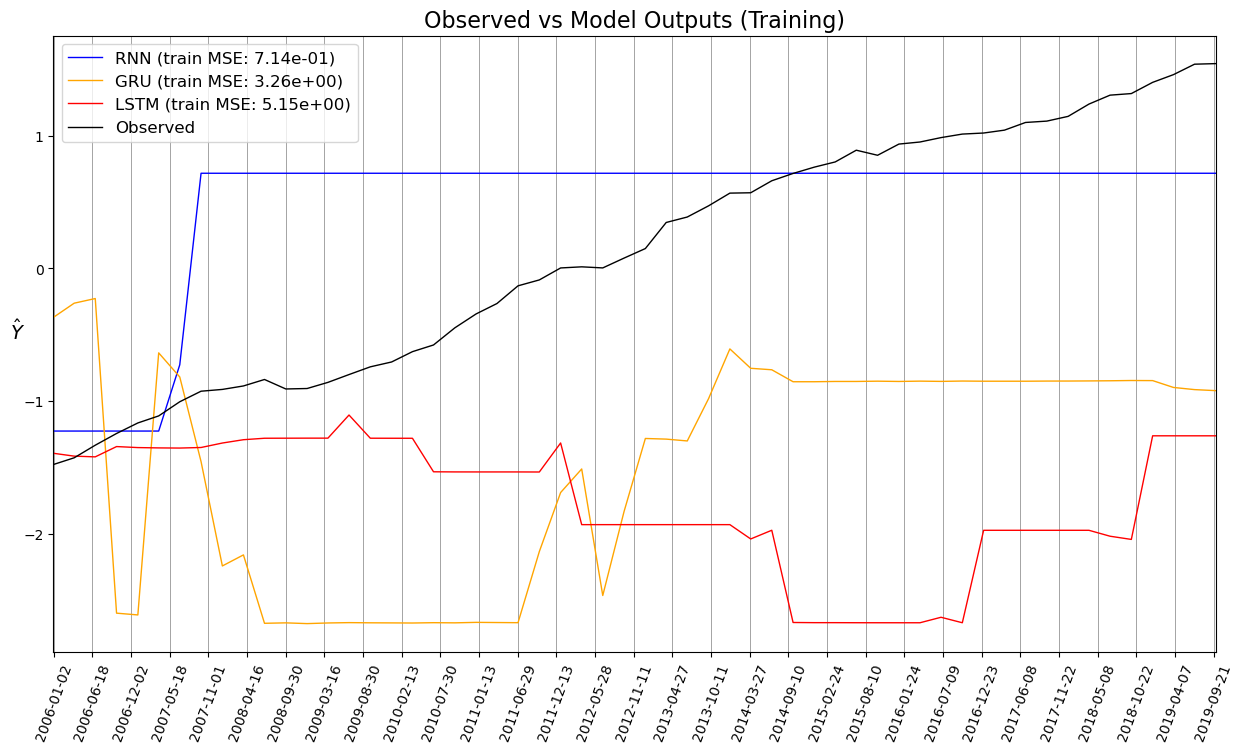

In [25]:
max_pts = 10**4
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable. 

fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_train[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Training)', fontsize=16);

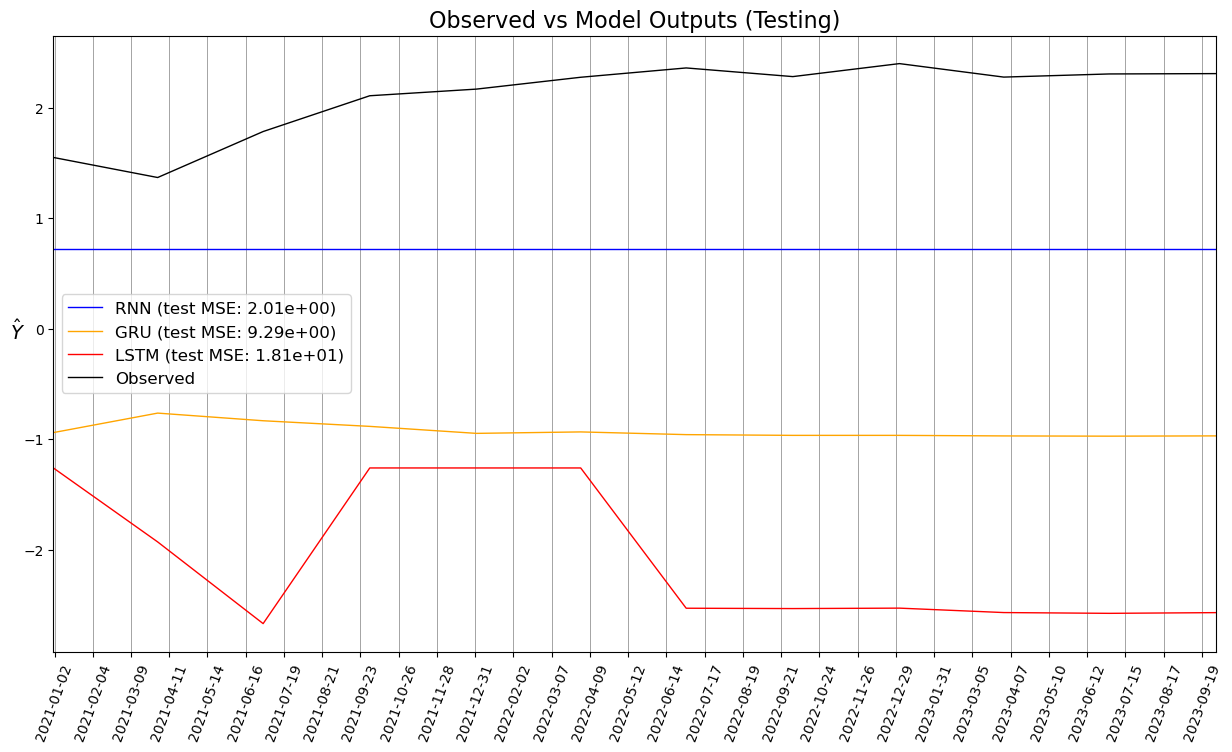

In [26]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_test[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16);

### MSE Dejando las Covariables sin Estandarizar

In [27]:
print('Modelo sin covariables de estacionalidad')
for key in params.keys():
    print('El MSE de la red',key, 'en el conjunto de prueba es',sigma**2*params[key]['MSE_test'])

Modelo sin covariables de estacionalidad
El MSE de la red rnn en el conjunto de prueba es 1697414571.7941418
El MSE de la red gru en el conjunto de prueba es 7834014613.422054
El MSE de la red lstm en el conjunto de prueba es 15228127492.378592


# Gráficos de predicción vs serie original
### Modelo sin covariables de tendencia y estacionalidad

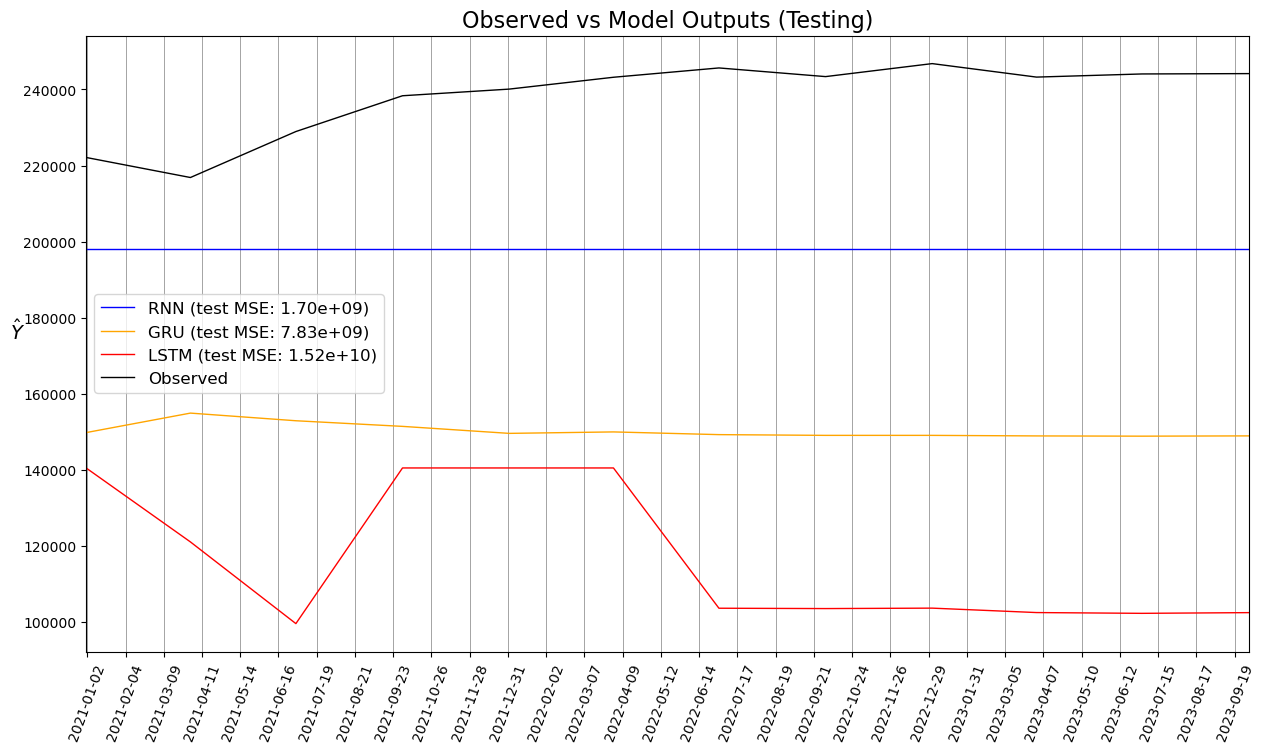

In [28]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = sigma*params[key]['pred_test'][l:u:ds]+mu
    label = params[key]['label'] + ' (test MSE: %.2e)' % (params[key]['MSE_test']*sigma**2)
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, mu+sigma*y_test[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16);